# Check UWD filled with ERA5

https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels

#### ERA5 hourly data on single levels from 1940 to present

- **Radiation and heat** / Surface net solar radiation
- **Radiation and heat** / Surface net solar thermal downwards
- **Radiation and heat** / Surface solar thermal downwards: `f88e980e24b1ba4fe8b42cb557ff66ae.nc`
- **Radiation and heat** / Surface solar radiation downwards: `8ef1b5ef403bac84d5778e9bf4b7e26f.nc`
- **Mean rates** / Mean surface downward long-wave radiation flux (test 2019): `23122b75afc3c080d1f85c7b5539b12f.nc`

Note: Mean rates = Radiation and heat/3600



------- 73.35 ------  
-80.05 ------- -79.8    
------- 73.1 ------  

(get 4 closest grid cells)

Downloaded by Mickaël Lalande 27/03/2025 (extend 2025 12/06/2025 + LWU and SWU)
  

In [1]:
# Env: sc2_v0
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xskillscore as xs
import calendar
import os

In [2]:
# Bylot TUNDRA station (Domine et al., 2021: https://essd.copernicus.org/articles/13/4331/2021/)
lat = 73.1504
lon = -80.0046

In [3]:
path = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot/ERA5'
path_land = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot/ERA5_Land'

## Surface long-wave (thermal) radiation downwards

In [5]:
ds_LWD_land = xr.open_mfdataset(path_land+'/ERA5_Land_2013.nc')
ds_LWD_land.load()

<xarray.Dataset> Size: 152kB
Dimensions:     (valid_time: 744, latitude: 3, longitude: 3)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 6kB 2013-01-01 ... 2013-01-31T23:...
  * latitude    (latitude) float64 24B 73.3 73.2 73.1
  * longitude   (longitude) float64 24B -80.05 -79.95 -79.85
    expver      (valid_time) <U4 12kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    ssr         (valid_time, latitude, longitude) float32 27kB 0.0 0.0 ... 0.0
    str         (valid_time, latitude, longitude) float32 27kB -2.027e+06 ......
    ssrd        (valid_time, latitude, longitude) float32 27kB 0.0 0.0 ... 0.0
    strd        (valid_time, latitude, longitude) float32 27kB 1.389e+07 ... ...
    sp          (valid_time, latitude, longitude) float32 27kB 9.67e+04 ... 9...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-12T20:06 GRIB to CDM+CF via cfgrib-0.9.1...

### Add Bylot TUNDRA coordinates

In [7]:
ds_LWD_land.latitude

<xarray.DataArray 'latitude' (latitude: 3)> Size: 24B
array([73.3, 73.2, 73.1])
Coordinates:
    number    int64 8B 0
  * latitude  (latitude) float64 24B 73.3 73.2 73.1
Attributes:
    units:             degrees_north
    standard_name:     latitude
    long_name:         latitude
    stored_direction:  decreasing

In [8]:
# Ajouter les nouvelles coordonnées
new_lats = np.sort(np.append(ds_LWD_land.latitude.values, lat))
new_lons = np.sort(np.append(ds_LWD_land.longitude.values, lon))

In [9]:
new_lats

array([73.1   , 73.1504, 73.2   , 73.3   ])

In [10]:
new_lons

array([-80.05  , -80.0046, -79.95  , -79.85  ])

In [11]:
ds_interp_land = ds_LWD_land.interp(latitude=new_lats, longitude=new_lons)
ds_interp_land

<xarray.Dataset> Size: 494kB
Dimensions:     (valid_time: 744, latitude: 4, longitude: 4)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 6kB 2013-01-01 ... 2013-01-31T23:...
    expver      (valid_time) <U4 12kB '0001' '0001' '0001' ... '0001' '0001'
  * latitude    (latitude) float64 32B 73.1 73.15 73.2 73.3
  * longitude   (longitude) float64 32B -80.05 -80.0 -79.95 -79.85
Data variables:
    ssr         (valid_time, latitude, longitude) float64 95kB 0.0 0.0 ... 0.0
    str         (valid_time, latitude, longitude) float64 95kB -1.838e+06 ......
    ssrd        (valid_time, latitude, longitude) float64 95kB 0.0 0.0 ... 0.0
    strd        (valid_time, latitude, longitude) float64 95kB 1.445e+07 ... ...
    sp          (valid_time, latitude, longitude) float64 95kB 9.932e+04 ... ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-12T20:06 GRIB to CDM+CF via cfgrib-0.9.1...

In [12]:
import warnings
warnings.filterwarnings('ignore')

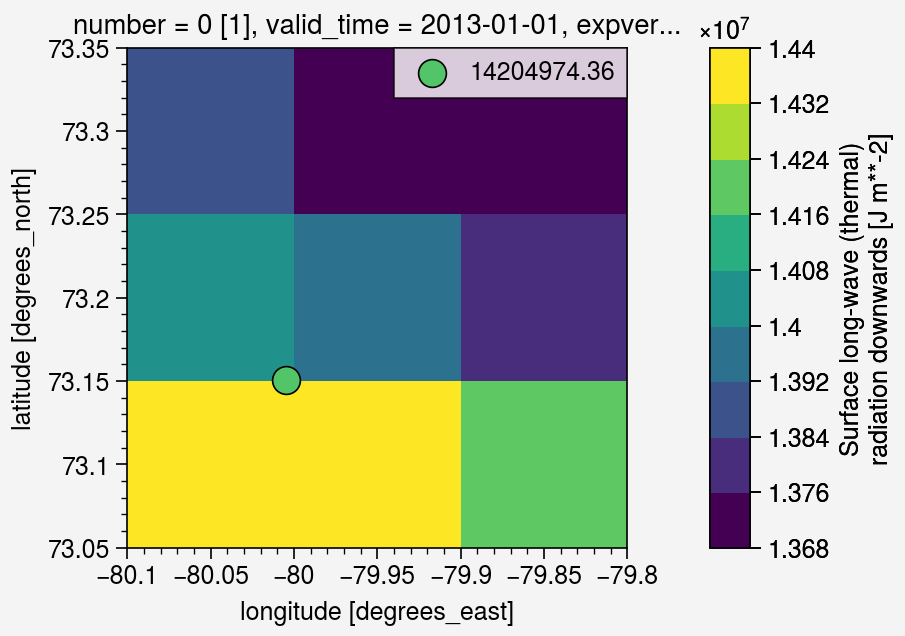

In [13]:
%matplotlib inline
fig, ax = pplt.subplots()

i_time = 0
pcolor = ds_LWD_land.strd[i_time].plot.pcolormesh(ax=ax)

# Récupérer les limites de la colorbar
vmin, vmax = pcolor.get_clim()

value = ds_interp_land.strd.sel(latitude=lat, longitude=lon)[i_time].item()  # Valeur scalaire

# Obtenir la couleur correspondante
import matplotlib.colors as mcolors  # Utilisation de matplotlib pour normaliser
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Normalisation correcte
cmap = pcolor.get_cmap()
color = cmap(norm(value))  # Convertir la valeur en couleur

# Ajouter le point avec la bonne couleur
ax.scatter(lon, lat, color=color, edgecolors="black", s=100, label=f"{value:.2f}")

# Afficher la légende
ax.legend()
pplt.show()

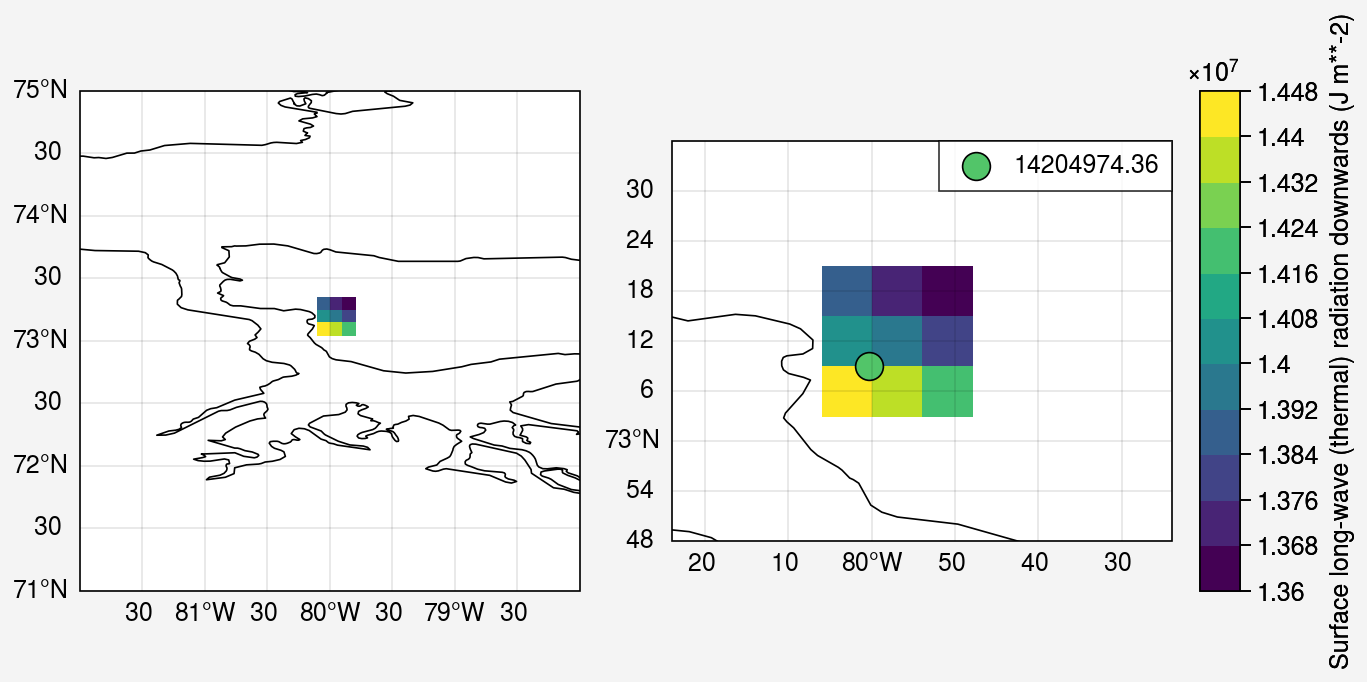

In [15]:
%matplotlib inline
fig, axs = pplt.subplots(proj='cyl', ncols=2)

i_time = 0
ax = axs[0]
ax.pcolormesh(ds_LWD_land.strd[i_time], cmap='viridis')

ax.format(
    borders=True, 
    coast=True, 
    labels=True, 
    latlim=(71, 75), 
    lonlim=(-82, -78),
    reso='hi'
)

ax = axs[1]
ax.pcolormesh(ds_LWD_land.strd[i_time], cmap='viridis', colorbar='r')

ax.format(
    borders=True, 
    coast=True, 
    labels=True, 
    latlim=(72.8, 73.6), 
    lonlim=(-79.4, -80.4),
    reso='hi'
)


# Récupérer les limites de la colorbar
vmin, vmax = pcolor.get_clim()

value = ds_interp_land.strd.sel(latitude=lat, longitude=lon)[i_time].item()  # Valeur scalaire

# Obtenir la couleur correspondante
import matplotlib.colors as mcolors  # Utilisation de matplotlib pour normaliser
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Normalisation correcte
cmap = pcolor.get_cmap()
color = cmap(norm(value))  # Convertir la valeur en couleur

# Ajouter le point avec la bonne couleur
ax.scatter(lon, lat, color=color, edgecolors="black", s=100, label=f"{value:.2f}")
ax.legend()

#reso : {'lo', 'med', 'hi', 'x-hi', 'xx-hi'}, optional


In [23]:
ds_LWD_land.strd[:, -1, 0]

<xarray.DataArray 'strd' (valid_time: 744)> Size: 3kB
array([14448810.  ,   504870.12,  1033129.44,  1528973.4 ,  2044456.5 ,
        2534882.5 ,  3048704.  ,  3536544.  ,  4029484.  ,  4562477.  ,
        5051349.5 ,  5544258.5 ,  6045832.5 ,  6552593.  ,  7062030.  ,
        7583181.5 ,  8067066.  ,  8550251.  ,  9025219.  ,  9509529.  ,
        9992036.  , 10500028.  , 10992172.  , 11469382.  , 11961991.  ,
         514014.1 ,  1021598.9 ,  1522538.5 ,  2024580.9 ,  2531015.  ,
        3023086.8 ,  3520904.  ,  4017743.  ,  4505068.5 ,  4981374.5 ,
        5466671.  ,  5938564.5 ,  6418352.5 ,  6879315.5 ,  7353298.  ,
        7838711.  ,  8320701.5 ,  8833763.  ,  9323894.  ,  9843729.  ,
       10363899.  , 10868254.  , 11410158.  , 11977222.  ,   564209.3 ,
        1163118.9 ,  1772252.1 ,  2359859.8 ,  2923610.  ,  3515607.8 ,
        4093355.5 ,  4700131.  ,  5309989.  ,  5915547.5 ,  6528041.  ,
        7153123.  ,  7755830.  ,  8359947.  ,  8956267.  ,  9566322.  ,
       10209660.  , 10861804.  , 11480809.  , 12091425.  , 12686641.  ,
       13266308.  , 13842080.  , 14398022.  ,   562724.1 ,  1109272.9 ,
        1638387.8 ,  2177011.2 ,  2708808.  ,  3228801.8 ,  3708160.2 ,
        4265766.5 ,  4761232.  ,  5240200.5 ,  5723035.  ,  6207073.5 ,
        6708120.  ,  7240773.5 ,  7713524.5 ,  8213598.5 ,  8705268.  ,
        9205537.  ,  9706913.  , 10262693.  , 10795596.  , 11322194.  ,
       11822003.  , 12309755.  ,   511684.5 ,  1020393.  ,  1524517.8 ,
...
       11705806.  , 12288858.  , 12914201.  , 13557259.  ,   657777.94,
        1311349.1 ,  1966739.  ,  2611653.5 ,  3213929.5 ,  3800648.8 ,
        4341500.5 ,  4883425.5 ,  5425945.  ,  5962750.5 ,  6511691.5 ,
        7057239.  ,  7597737.5 ,  8119706.5 ,  8631265.  ,  9149954.  ,
        9659793.  , 10197580.  , 10742776.  , 11278488.  , 11795341.  ,
       12309105.  , 12800478.  , 13309791.  ,   511929.1 ,  1014830.6 ,
        1532898.4 ,  2053663.1 ,  2564239.8 ,  3074514.8 ,  3564066.5 ,
        4087960.8 ,  4607011.  ,  5098445.  ,  5598095.5 ,  6061292.5 ,
        6548886.5 ,  7050149.5 ,  7525796.  ,  8040405.  ,  8545699.  ,
        9063065.  ,  9570345.  , 10097682.  , 10619103.  , 11165701.  ,
       11707973.  , 12275275.  ,   570834.06,  1130645.  ,  1689503.2 ,
        2236882.5 ,  2758529.8 ,  3287162.8 ,  3829707.5 ,  4364963.5 ,
        4864413.  ,  5370515.5 ,  5865655.  ,  6379583.5 ,  6894714.  ,
        7397301.  ,  7901560.  ,  8425712.  ,  8945156.  ,  9444620.  ,
        9937312.  , 10418344.  , 10916908.  , 11422942.  , 11925516.  ,
       12425095.  ,   512833.1 ,  1021423.  ,  1520248.  ,  2007229.4 ,
        2498376.  ,  2983255.5 ,  3472499.8 ,  3960875.8 ,  4442593.  ,
        4915079.  ,  5405997.5 ,  5885754.  ,  6360407.5 ,  6829742.5 ,
        7292762.5 ,  7776173.5 ,  8245460.5 ,  8716567.  ,  9171459.  ,
        9640153.  , 10110804.  , 10587963.  , 11054147.  ], dtype=float32)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 6kB 2013-01-01 ... 2013-01-31T23:...
    latitude    float64 8B 73.1
    longitude   float64 8B -80.05
    expver      (valid_time) <U4 12kB '0001' '0001' '0001' ... '0001' '0001'
Attributes: (12/32)
    GRIB_paramId:                             175
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      9
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               J m**-2
    long_name:                                Surface long-wave (thermal) rad...
    units:                                    J m**-2
    standard_name:                            unknown
    GRIB_surface:                             0.0

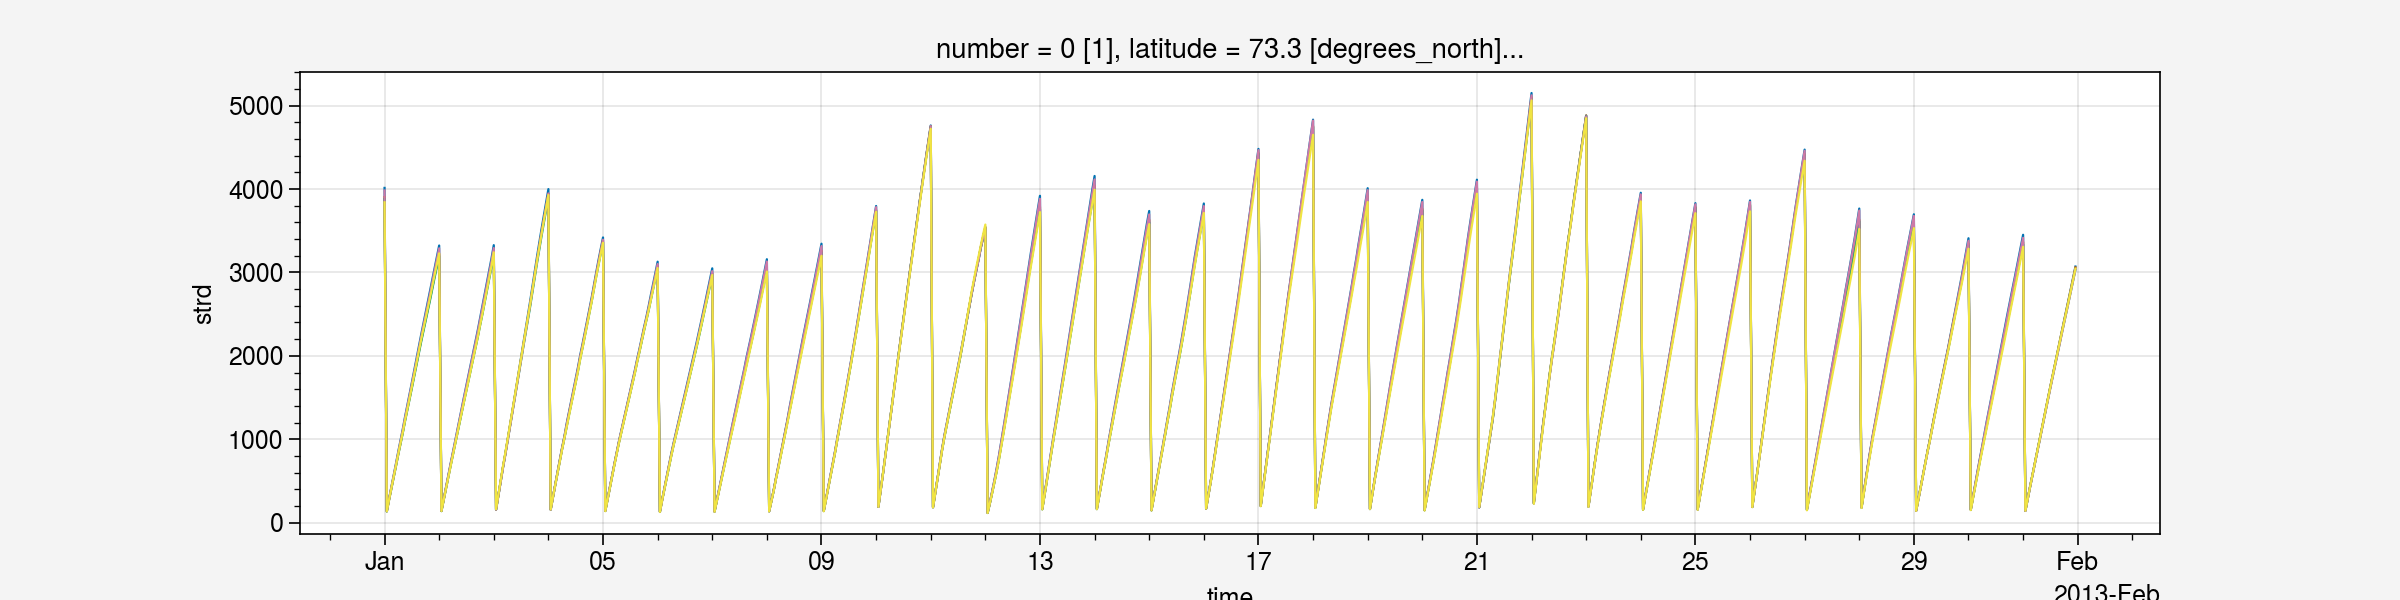

In [27]:
(ds_LWD_land.strd[:, -1, 0]/3600).plot(figsize=(12,3), lw=0.8)
(ds_LWD_land.strd[:, -2, 0]/3600).plot(lw=0.8)
(ds_LWD_land.strd[:, -2, 1]/3600).plot(lw=0.8)
(ds_LWD_land.strd[:, -1, 1]/3600).plot(lw=0.8)
(ds_interp_land.strd[:, -1, 1]/3600).plot(lw=0.8)

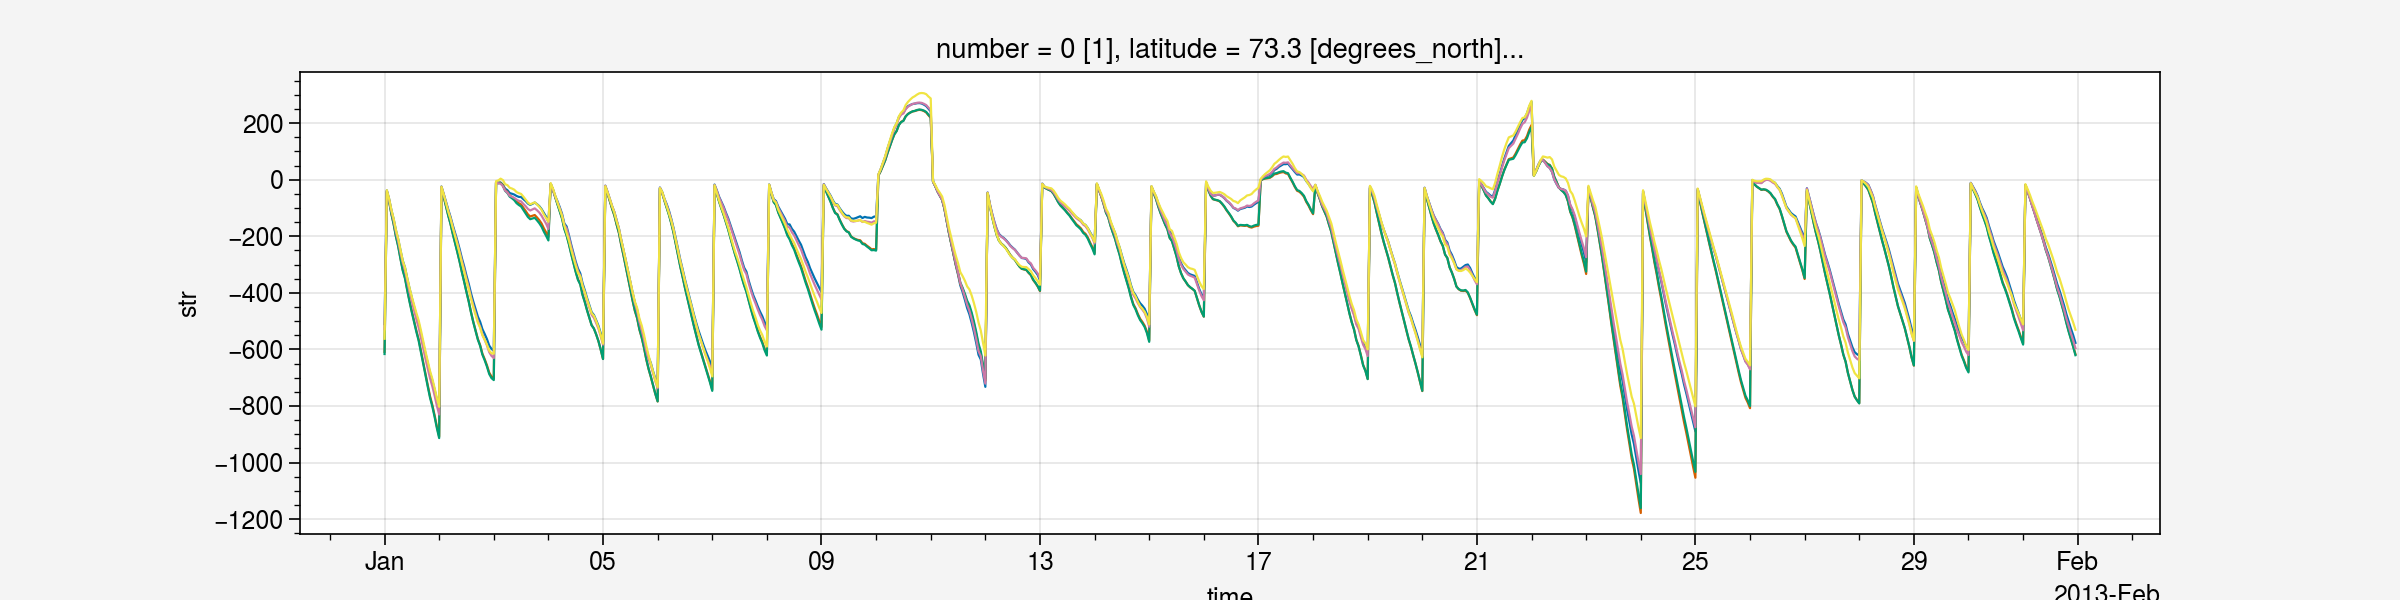

In [30]:
(ds_LWD_land.str[:, -1, 0]/3600).plot(figsize=(12,3), lw=0.8)
(ds_LWD_land.str[:, -2, 0]/3600).plot(lw=0.8)
(ds_LWD_land.str[:, -2, 1]/3600).plot(lw=0.8)
(ds_LWD_land.str[:, -1, 1]/3600).plot(lw=0.8)
(ds_interp_land.str[:, -1, 1]/3600).plot(lw=0.8)

In [4]:
ds_LWD = xr.open_mfdataset(path+'/LW_down/*.nc')
ds_LWD.load()

<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 107111, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 857kB 2013-01-01 ... 2025-03-21T2...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    strd        (valid_time, latitude, longitude) float32 2MB 4.96e+05 ... 6....
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-04T20:54 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
ds_LWD_2025 = xr.open_mfdataset(path+'/LW_down/2025/*.nc')
ds_LWD_2025.load()

<xarray.Dataset> Size: 151kB
Dimensions:     (valid_time: 3766, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 30kB 2025-01-01 ... 2025-06-06T21...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 60kB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    strd        (valid_time, latitude, longitude) float32 60kB 6.527e+05 ... ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-11T21:14 GRIB to CDM+CF via cfgrib-0.9.1...

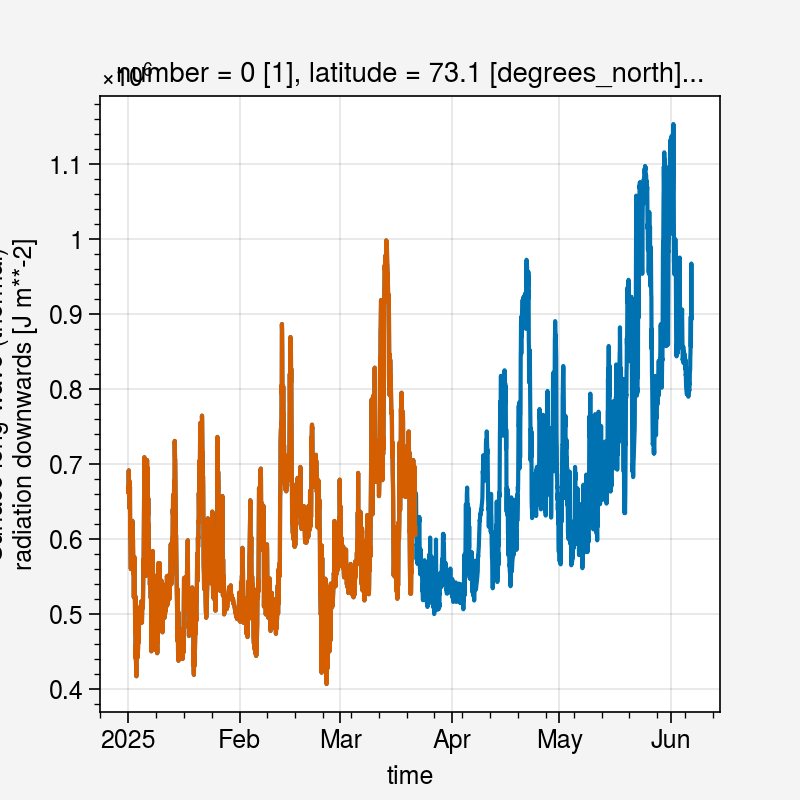

In [6]:
ds_LWD_2025.strd.sel(latitude=73.1, longitude=-80.05).plot()
ds_LWD.strd.sel(latitude=73.1, longitude=-80.05, valid_time='2025').plot()

In [7]:
ds_LWD.sel(valid_time=slice('2013', '2024'))

<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 105192, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 842kB 2013-01-01 ... 2024-12-31T2...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    strd        (valid_time, latitude, longitude) float32 2MB 4.96e+05 ... 6....
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-04T20:54 GRIB to CDM+CF via cfgrib-0.9.1...

Be aware the expver 0005 is not the final version

In [8]:
ds_LWD_2025

<xarray.Dataset> Size: 151kB
Dimensions:     (valid_time: 3766, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 30kB 2025-01-01 ... 2025-06-06T21...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 60kB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    strd        (valid_time, latitude, longitude) float32 60kB 6.527e+05 ... ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-11T21:14 GRIB to CDM+CF via cfgrib-0.9.1...

In [9]:
ds_LWD_2025.sel(valid_time=slice('2025-01-01', '2025-03'))

<xarray.Dataset> Size: 86kB
Dimensions:     (valid_time: 2160, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 17kB 2025-01-01 ... 2025-03-31T23...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 35kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    strd        (valid_time, latitude, longitude) float32 35kB 6.527e+05 ... ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-11T21:14 GRIB to CDM+CF via cfgrib-0.9.1...

In [10]:
105192+3766

108958

In [11]:
ds_LWD_concat = xr.concat([ds_LWD.sel(valid_time=slice('2013', '2024')), ds_LWD_2025], dim="valid_time")
ds_LWD_concat

<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 108958, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 872kB 2013-01-01 ... 2025-06-06T2...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    strd        (valid_time, latitude, longitude) float32 2MB 4.96e+05 ... 8....
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-04T20:54 GRIB to CDM+CF via cfgrib-0.9.1...

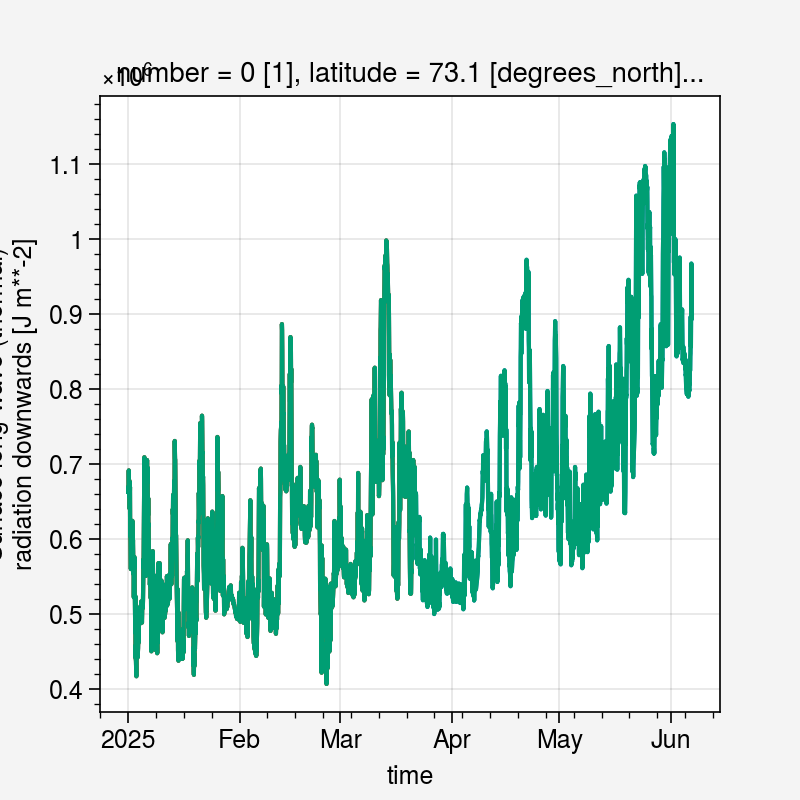

In [12]:
ds_LWD_2025.strd.sel(latitude=73.1, longitude=-80.05).plot()
ds_LWD.strd.sel(latitude=73.1, longitude=-80.05, valid_time='2025').plot()
ds_LWD_concat.strd.sel(latitude=73.1, longitude=-80.05, valid_time='2025').plot()

## Surface long-wave net (thermal) radiation

In [13]:
ds_LW_net = xr.open_mfdataset(path+'/LW_net/*.nc')
ds_LW_net.load()

<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 108955, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 872kB 2013-01-01 ... 2025-06-06T1...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    str         (valid_time, latitude, longitude) float32 2MB -1.178e+05 ... ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-11T17:00 GRIB to CDM+CF via cfgrib-0.9.1...

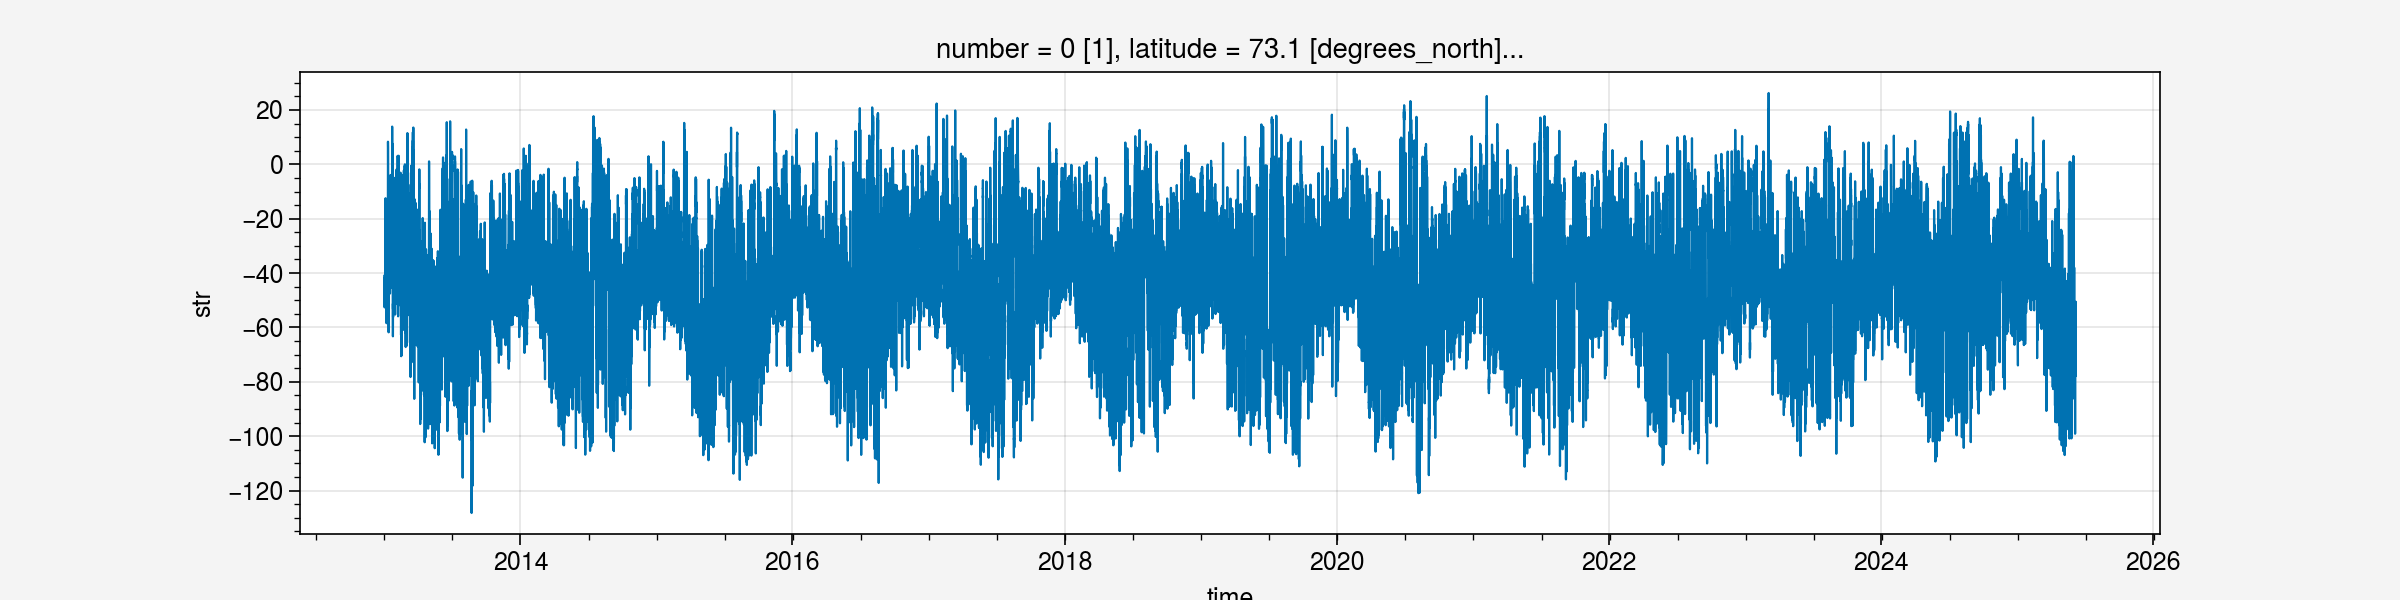

In [14]:
%matplotlib inline
(ds_LW_net.str/3600).sel(latitude=73.1, longitude=-80.05).plot(figsize=(12,3), lw=0.8)

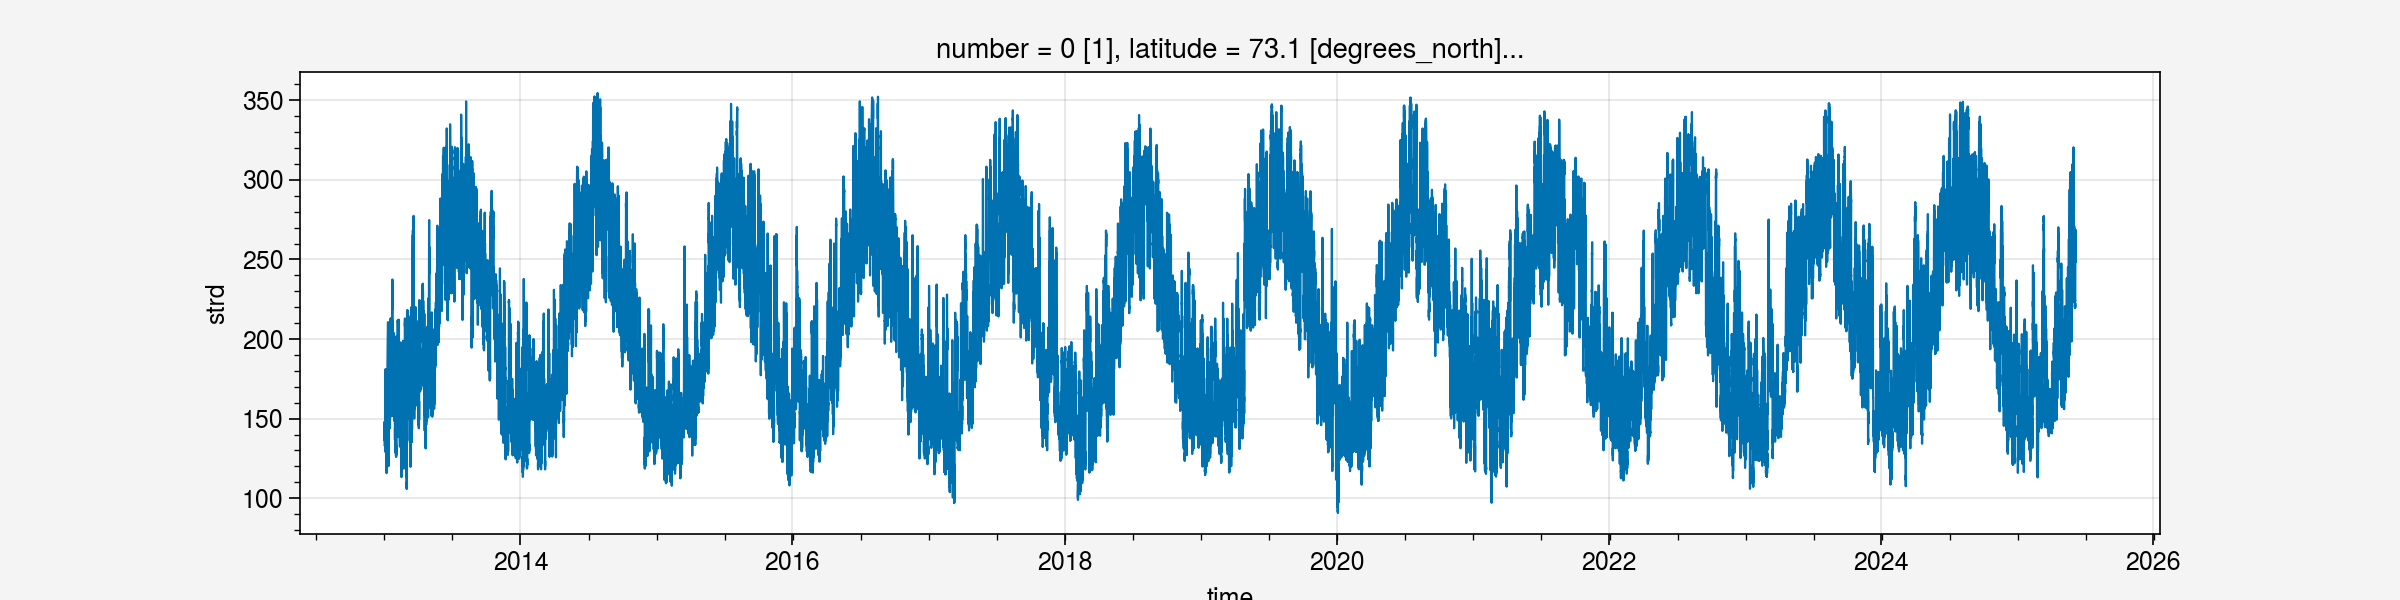

In [15]:
%matplotlib inline
(ds_LWD_concat.strd/3600).sel(latitude=73.1, longitude=-80.05).plot(figsize=(12,3), lw=0.8)

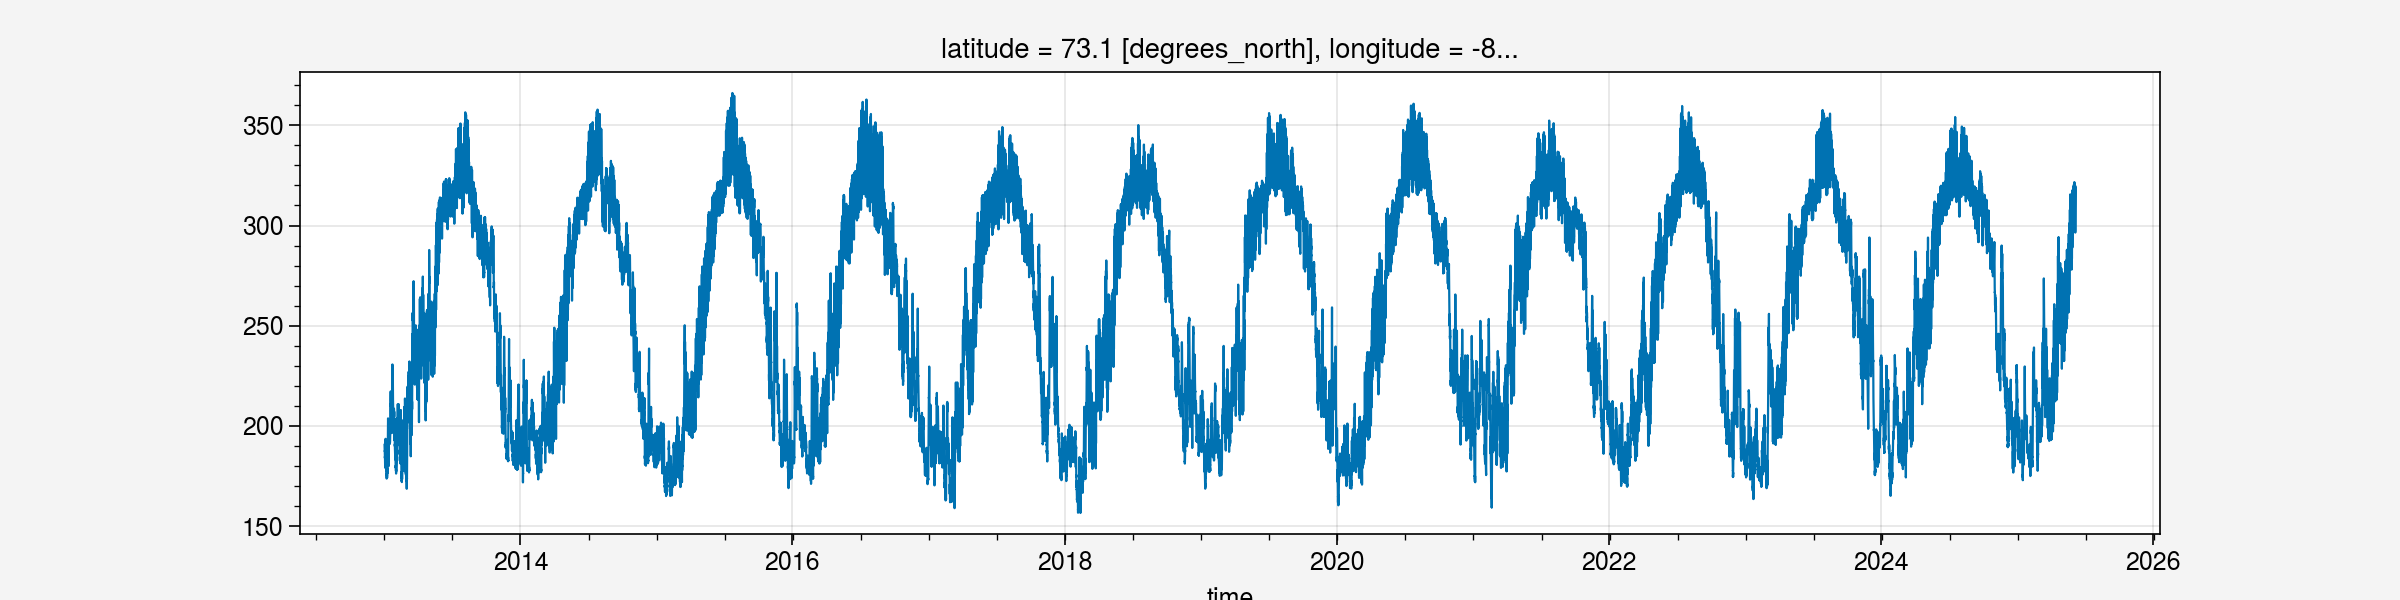

In [16]:
%matplotlib inline
((ds_LWD_concat.strd - ds_LW_net.str)/3600).sel(latitude=73.1, longitude=-80.05).plot(figsize=(12,3), lw=0.8)

## Gather all variable in one dataset

In [17]:
ds_all = ds_LWD_concat/3600 # convert to W/m2
ds_all

<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 108958, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 872kB 2013-01-01 ... 2025-06-06T2...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    strd        (valid_time, latitude, longitude) float32 2MB 137.8 ... 249.0
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-04T20:54 GRIB to CDM+CF via cfgrib-0.9.1...

In [18]:
ds_all['str'] = ds_LW_net.str/3600 # convert to W/m2
ds_all['stru'] = (ds_LWD_concat.strd - ds_LW_net.str)/3600 # convert to W/m2
ds_all

<xarray.Dataset> Size: 8MB
Dimensions:     (valid_time: 108958, latitude: 2, longitude: 2)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 872kB 2013-01-01 ... 2025-06-06T2...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    number      int64 8B 0
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    strd        (valid_time, latitude, longitude) float32 2MB 137.8 ... 249.0
    str         (valid_time, latitude, longitude) float32 2MB -32.72 ... nan
    stru        (valid_time, latitude, longitude) float32 2MB 170.5 ... nan
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-04T20:54 GRIB to CDM+CF via cfgrib-0.9.1...

## Surface short-wave (solar) radiation downwards

In [19]:
ds_SWD = xr.open_mfdataset(path+'/SW_down/*.nc')
ds_SWD.load()

<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 107110, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 857kB 2013-01-01 ... 2025-03-21T2...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    ssrd        (valid_time, latitude, longitude) float32 2MB 0.0 ... 6.123e+05
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-04T20:26 GRIB to CDM+CF via cfgrib-0.9.1...

In [20]:
ds_SWD_2025 = xr.open_mfdataset(path+'/SW_down/2025/*.nc')
ds_SWD_2025.load()

<xarray.Dataset> Size: 151kB
Dimensions:     (valid_time: 3766, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 30kB 2025-01-01 ... 2025-06-06T21...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 60kB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    ssrd        (valid_time, latitude, longitude) float32 60kB 0.0 ... 1.96e+06
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-11T21:18 GRIB to CDM+CF via cfgrib-0.9.1...

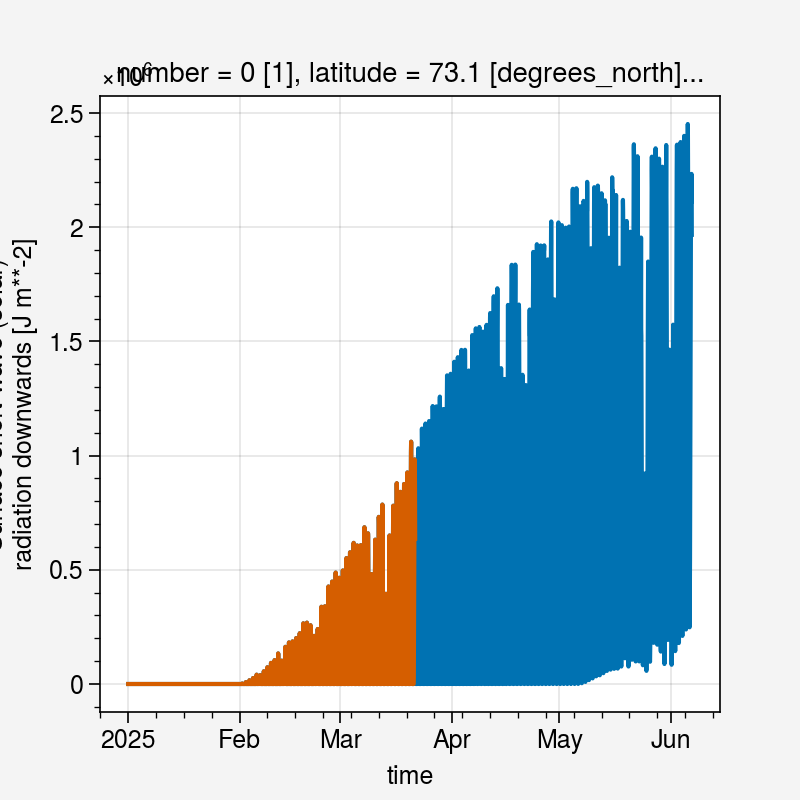

In [21]:
ds_SWD_2025.ssrd.sel(latitude=73.1, longitude=-80.05).plot()
ds_SWD.ssrd.sel(latitude=73.1, longitude=-80.05, valid_time='2025').plot()

In [22]:
ds_SWD.sel(valid_time=slice('2013', '2024'))

<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 105192, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 842kB 2013-01-01 ... 2024-12-31T2...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    ssrd        (valid_time, latitude, longitude) float32 2MB 0.0 0.0 ... 0.0
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-04T20:26 GRIB to CDM+CF via cfgrib-0.9.1...

Be aware the expver 0005 is not the final version

In [23]:
ds_SWD_2025

<xarray.Dataset> Size: 151kB
Dimensions:     (valid_time: 3766, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 30kB 2025-01-01 ... 2025-06-06T21...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 60kB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    ssrd        (valid_time, latitude, longitude) float32 60kB 0.0 ... 1.96e+06
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-11T21:18 GRIB to CDM+CF via cfgrib-0.9.1...

In [24]:
105192+3766

108958

In [25]:
ds_SWD_concat = xr.concat([ds_SWD.sel(valid_time=slice('2013', '2024')), ds_SWD_2025], dim="valid_time")
ds_SWD_concat

<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 108958, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 872kB 2013-01-01 ... 2025-06-06T2...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    ssrd        (valid_time, latitude, longitude) float32 2MB 0.0 ... 1.96e+06
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-04T20:26 GRIB to CDM+CF via cfgrib-0.9.1...

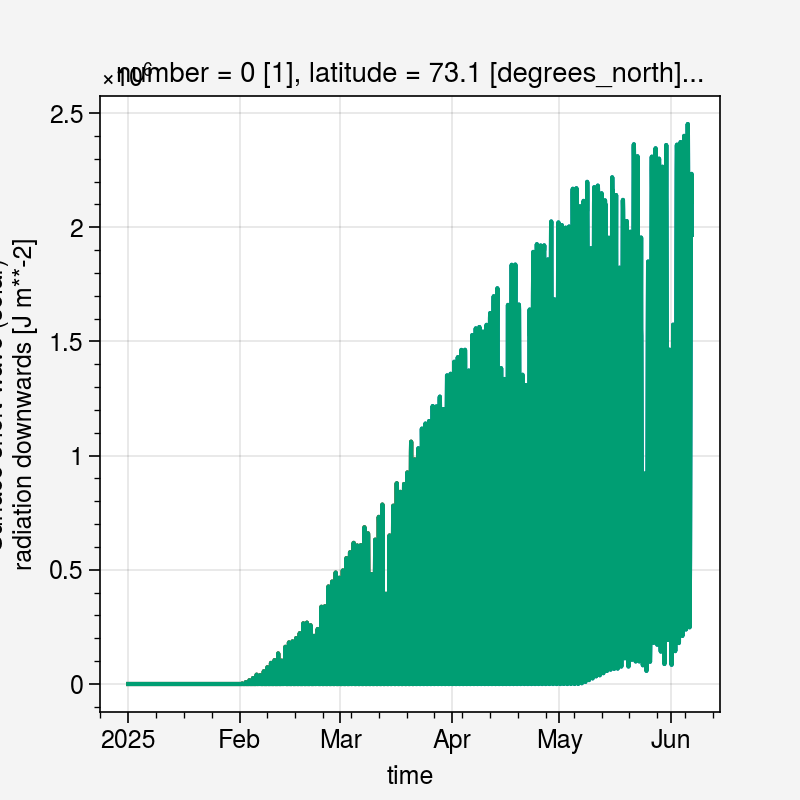

In [26]:
ds_SWD_2025.ssrd.sel(latitude=73.1, longitude=-80.05).plot()
ds_SWD.ssrd.sel(latitude=73.1, longitude=-80.05, valid_time='2025').plot()
ds_SWD_concat.ssrd.sel(latitude=73.1, longitude=-80.05, valid_time='2025').plot()

## Surface short-wave net (solar) radiation

In [27]:
ds_SW_net = xr.open_mfdataset(path+'/SW_net/*.nc')
ds_SW_net.load()

<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 108958, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 872kB 2013-01-01 ... 2025-06-06T2...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    ssr         (valid_time, latitude, longitude) float32 2MB 3.6e-12 ... 1.0...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-11T19:44 GRIB to CDM+CF via cfgrib-0.9.1...

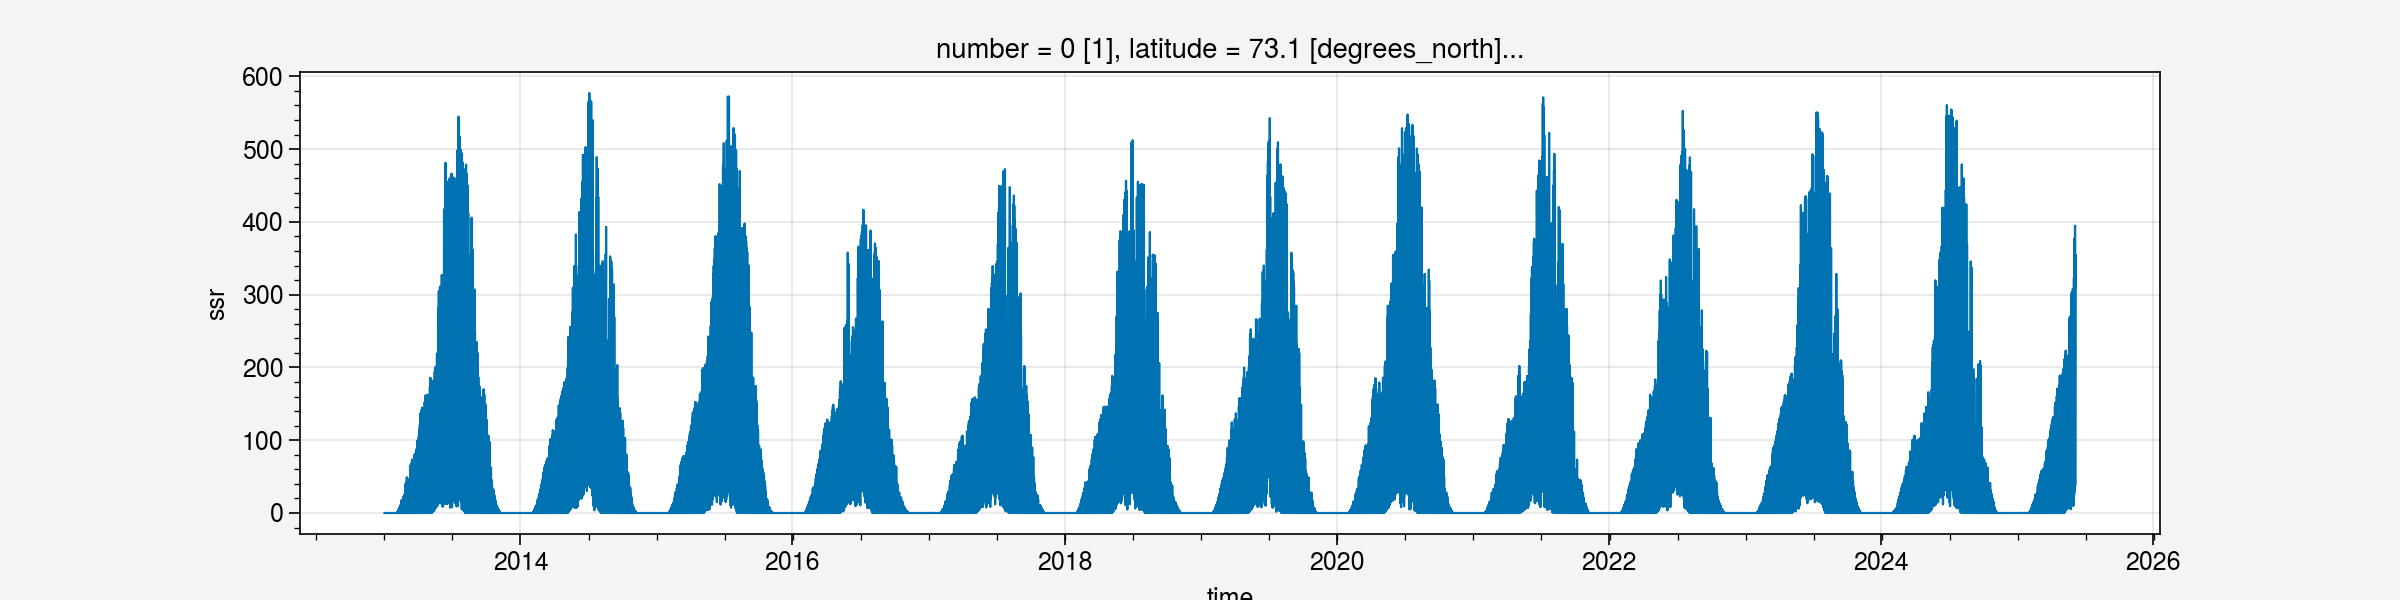

In [28]:
%matplotlib inline
(ds_SW_net.ssr/3600).sel(latitude=73.1, longitude=-80.05).plot(figsize=(12,3), lw=0.8)

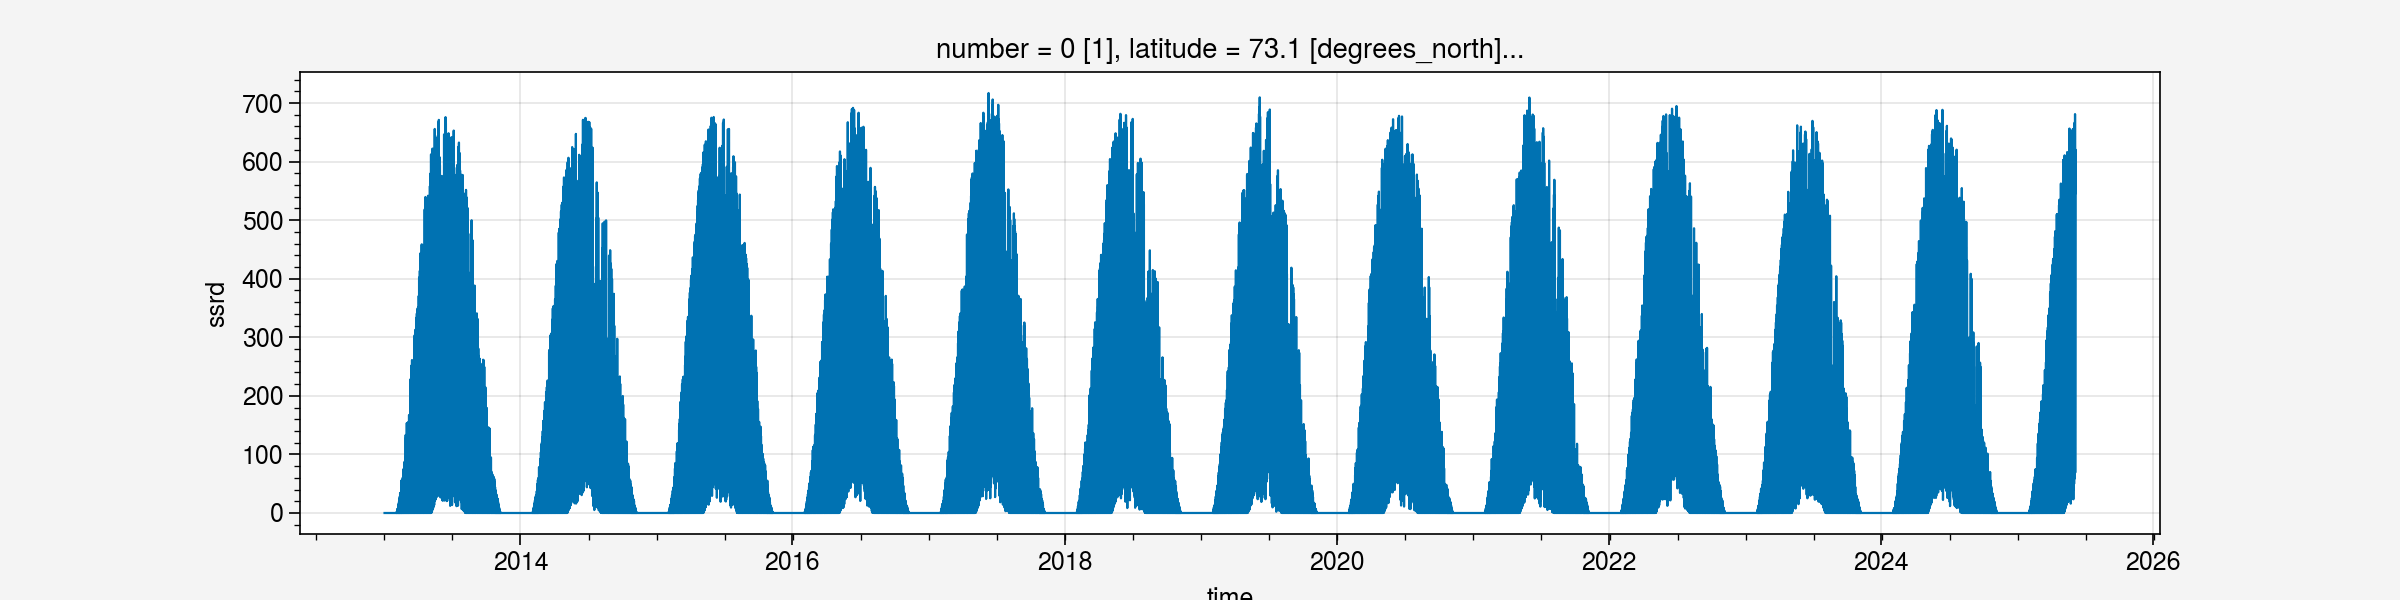

In [32]:
%matplotlib inline
(ds_SWD_concat.ssrd/3600).sel(latitude=73.1, longitude=-80.05).plot(figsize=(12,3), lw=0.8)

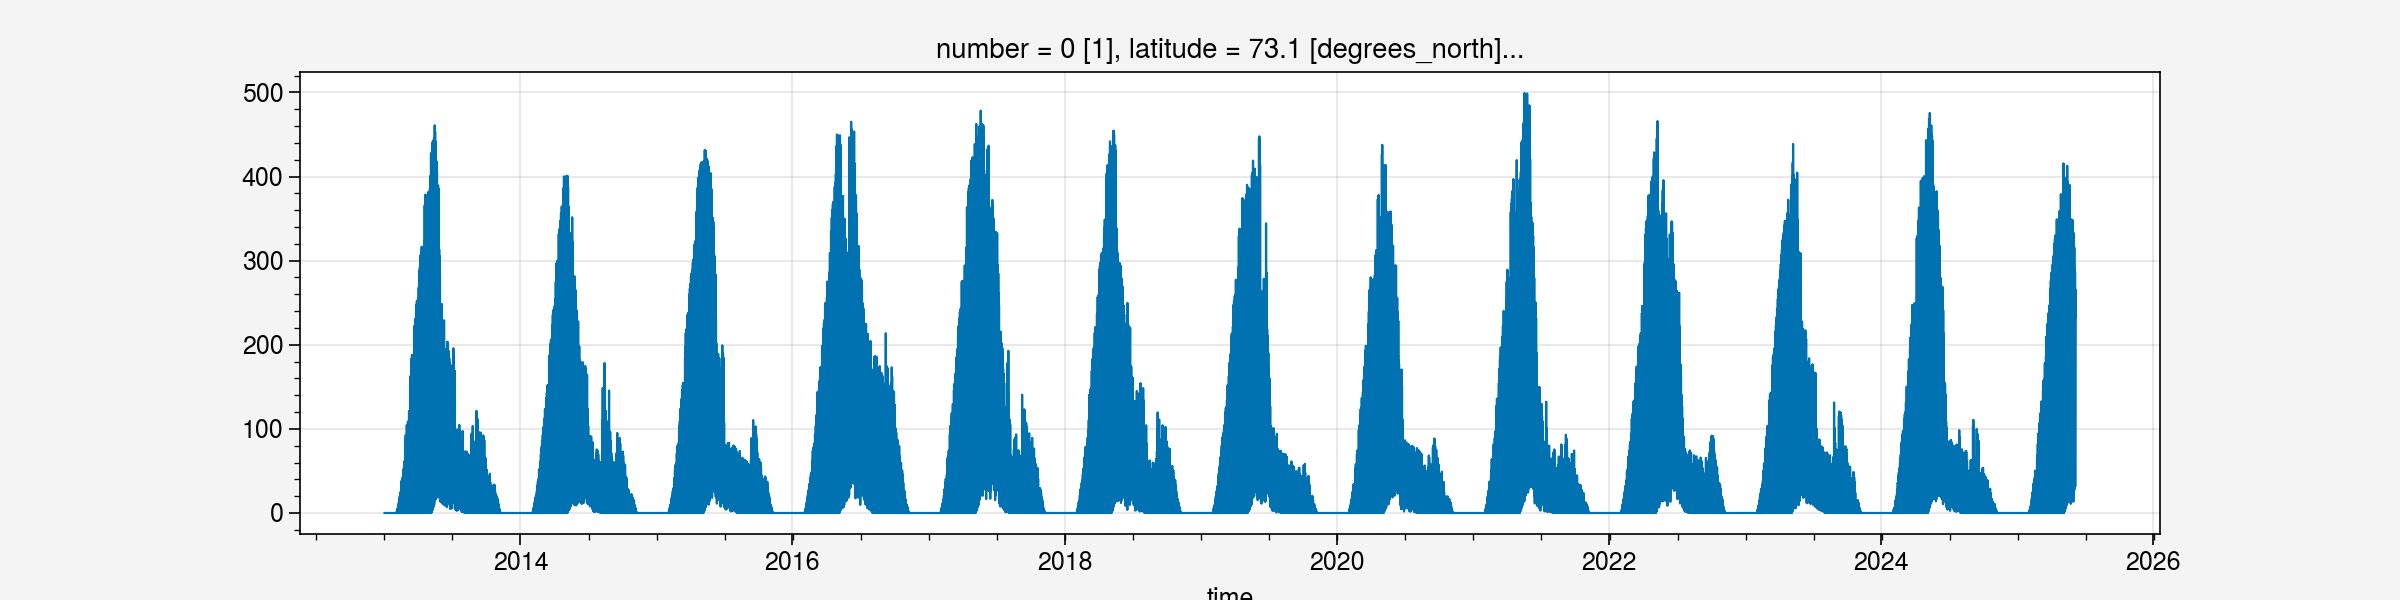

In [30]:
%matplotlib inline
((ds_SWD_concat.ssrd - ds_SW_net.ssr)/3600).sel(latitude=73.1, longitude=-80.05).plot(figsize=(12,3), lw=0.8)

In [65]:
ds_SWD_concat.ssrd

<xarray.DataArray 'ssrd' (valid_time: 108958, latitude: 2, longitude: 2)> Size: 2MB
array([[[      0.,       0.],
        [      0.,       0.]],

       [[      0.,       0.],
        [      0.,       0.]],

       [[      0.,       0.],
        [      0.,       0.]],

       ...,

       [[2306496., 2340296.],
        [2233822., 2261300.]],

       [[2150640., 2174643.],
        [2121286., 2112098.]],

       [[1981764., 2010608.],
        [1966939., 1960395.]]], dtype=float32)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 872kB 2013-01-01 ... 2025-06-06T2...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
Attributes: (12/32)
    GRIB_paramId:                             169
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      4
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               J m**-2
    long_name:                                Surface short-wave (solar) radi...
    units:                                    J m**-2
    standard_name:                            surface_downwelling_shortwave_f...
    GRIB_surface:                             0.0

In [66]:
ds_SW_net.ssr

<xarray.DataArray 'ssr' (valid_time: 108958, latitude: 2, longitude: 2)> Size: 2MB
array([[[3.5999988e-12, 3.5999988e-12],
        [3.5999988e-12, 3.5999988e-12]],

       [[3.5999988e-12, 3.5999988e-12],
        [3.5999988e-12, 3.5999988e-12]],

       [[3.5999988e-12, 3.5999988e-12],
        [3.5999988e-12, 3.5999988e-12]],

       ...,

       [[9.5141644e+05, 7.8140044e+05],
        [1.2779125e+06, 1.1524645e+06]],

       [[9.0017106e+05, 7.3264306e+05],
        [1.2218990e+06, 1.0858910e+06]],

       [[8.2830081e+05, 6.7184481e+05],
        [1.1270688e+06, 1.0033168e+06]]], dtype=float32)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 872kB 2013-01-01 ... 2025-06-06T2...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
Attributes: (12/32)
    GRIB_paramId:                             176
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      4
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               J m**-2
    long_name:                                Surface net short-wave (solar) ...
    units:                                    J m**-2
    standard_name:                            surface_net_downward_shortwave_...
    GRIB_surface:                             0.0

## Gather all variable in one dataset

In [70]:
ds_all['ssrd'] = ds_SWD_concat.ssrd/3600 # convert to W/m2
ds_all['ssr'] = ds_SW_net.ssr/3600 # convert to W/m2
ds_all['ssru'] = (ds_SWD_concat.ssrd - ds_SW_net.ssr)/3600 # convert to W/m2
ds_all

<xarray.Dataset> Size: 13MB
Dimensions:     (valid_time: 108958, latitude: 2, longitude: 2)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 872kB 2013-01-01 ... 2025-06-06T2...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    number      int64 8B 0
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    strd        (valid_time, latitude, longitude) float32 2MB 137.8 ... 249.0
    str         (valid_time, latitude, longitude) float32 2MB -32.72 ... nan
    stru        (valid_time, latitude, longitude) float32 2MB 170.5 ... nan
    ssrd        (valid_time, latitude, longitude) float32 2MB 0.0 0.0 ... 544.6
    ssr         (valid_time, latitude, longitude) float32 2MB 1e-15 ... 278.7
    ssru        (valid_time, latitude, longitude) float32 2MB -1e-15 ... 265.9
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-04T20:54 GRIB to CDM+CF via cfgrib-0.9.1...

## Mean_sea_level_pressure

In [71]:
ds_msl = xr.open_mfdataset(path+'/Mean_sea_level_pressure/*.nc')
ds_msl.load()

<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 102807, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 822kB 2013-07-01 ... 2025-03-23T1...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    msl         (valid_time, latitude, longitude) float32 2MB 1.006e+05 ... 1...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-01T14:06 GRIB to CDM+CF via cfgrib-0.9.1...

In [72]:
ds_msl_2025 = xr.open_mfdataset(path+'/Mean_sea_level_pressure/2025/*.nc')
ds_msl_2025.load()

<xarray.Dataset> Size: 151kB
Dimensions:     (valid_time: 3766, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 30kB 2025-01-01 ... 2025-06-06T21...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 60kB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    msl         (valid_time, latitude, longitude) float32 60kB 1.03e+05 ... 1...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-11T21:22 GRIB to CDM+CF via cfgrib-0.9.1...

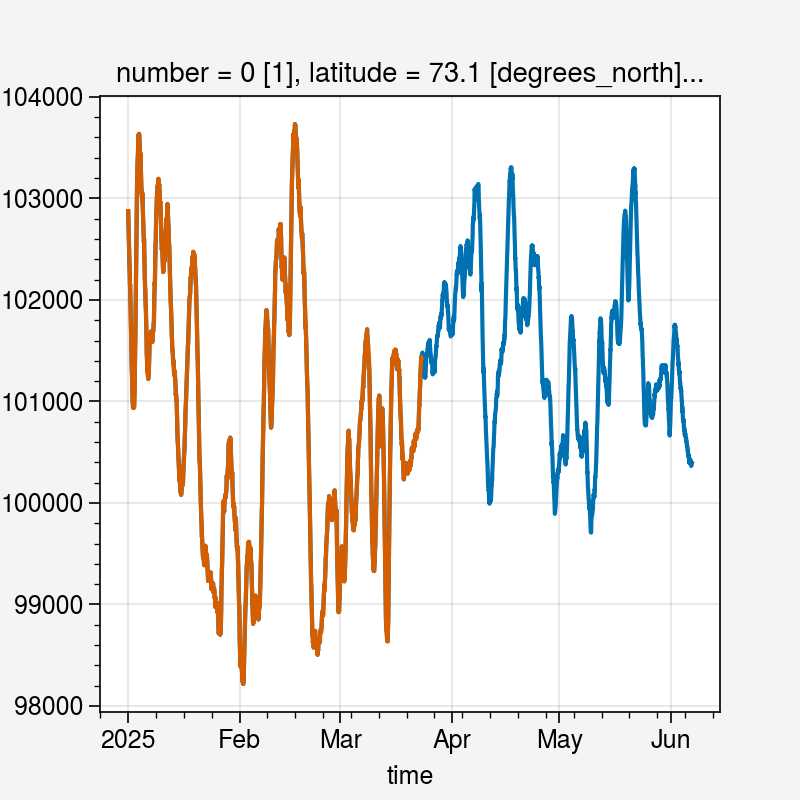

In [73]:
ds_msl_2025.msl.sel(latitude=73.1, longitude=-80.05).plot()
ds_msl.msl.sel(latitude=73.1, longitude=-80.05, valid_time='2025').plot()

In [74]:
ds_msl.sel(valid_time=slice('2013', '2024'))

<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 100848, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 807kB 2013-07-01 ... 2024-12-31T2...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    msl         (valid_time, latitude, longitude) float32 2MB 1.006e+05 ... 1...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-01T14:06 GRIB to CDM+CF via cfgrib-0.9.1...

Be aware the expver 0005 is not the final version

In [75]:
ds_msl_2025

<xarray.Dataset> Size: 151kB
Dimensions:     (valid_time: 3766, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 30kB 2025-01-01 ... 2025-06-06T21...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 60kB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    msl         (valid_time, latitude, longitude) float32 60kB 1.03e+05 ... 1...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-11T21:22 GRIB to CDM+CF via cfgrib-0.9.1...

In [76]:
100848+3766

104614

In [77]:
ds_msl_concat = xr.concat([ds_msl.sel(valid_time=slice('2013', '2024')), ds_msl_2025], dim="valid_time")
ds_msl_concat

<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 104614, latitude: 2, longitude: 2)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 837kB 2013-07-01 ... 2025-06-06T2...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    msl         (valid_time, latitude, longitude) float32 2MB 1.006e+05 ... 1...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-01T14:06 GRIB to CDM+CF via cfgrib-0.9.1...

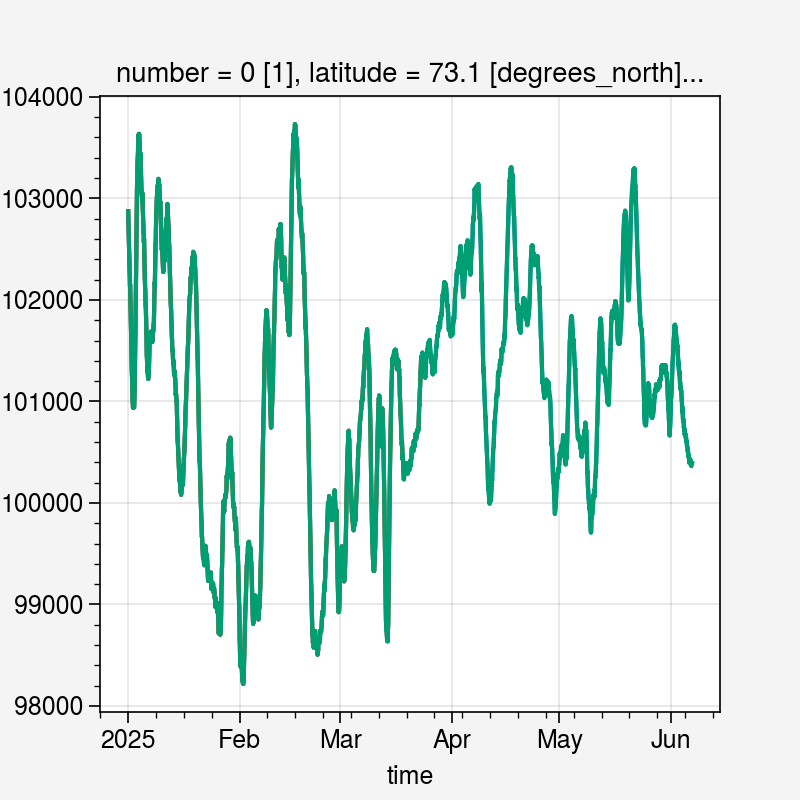

In [78]:
ds_msl_2025.msl.sel(latitude=73.1, longitude=-80.05).plot()
ds_msl.msl.sel(latitude=73.1, longitude=-80.05, valid_time='2025').plot()
ds_msl_concat.msl.sel(latitude=73.1, longitude=-80.05, valid_time='2025').plot()

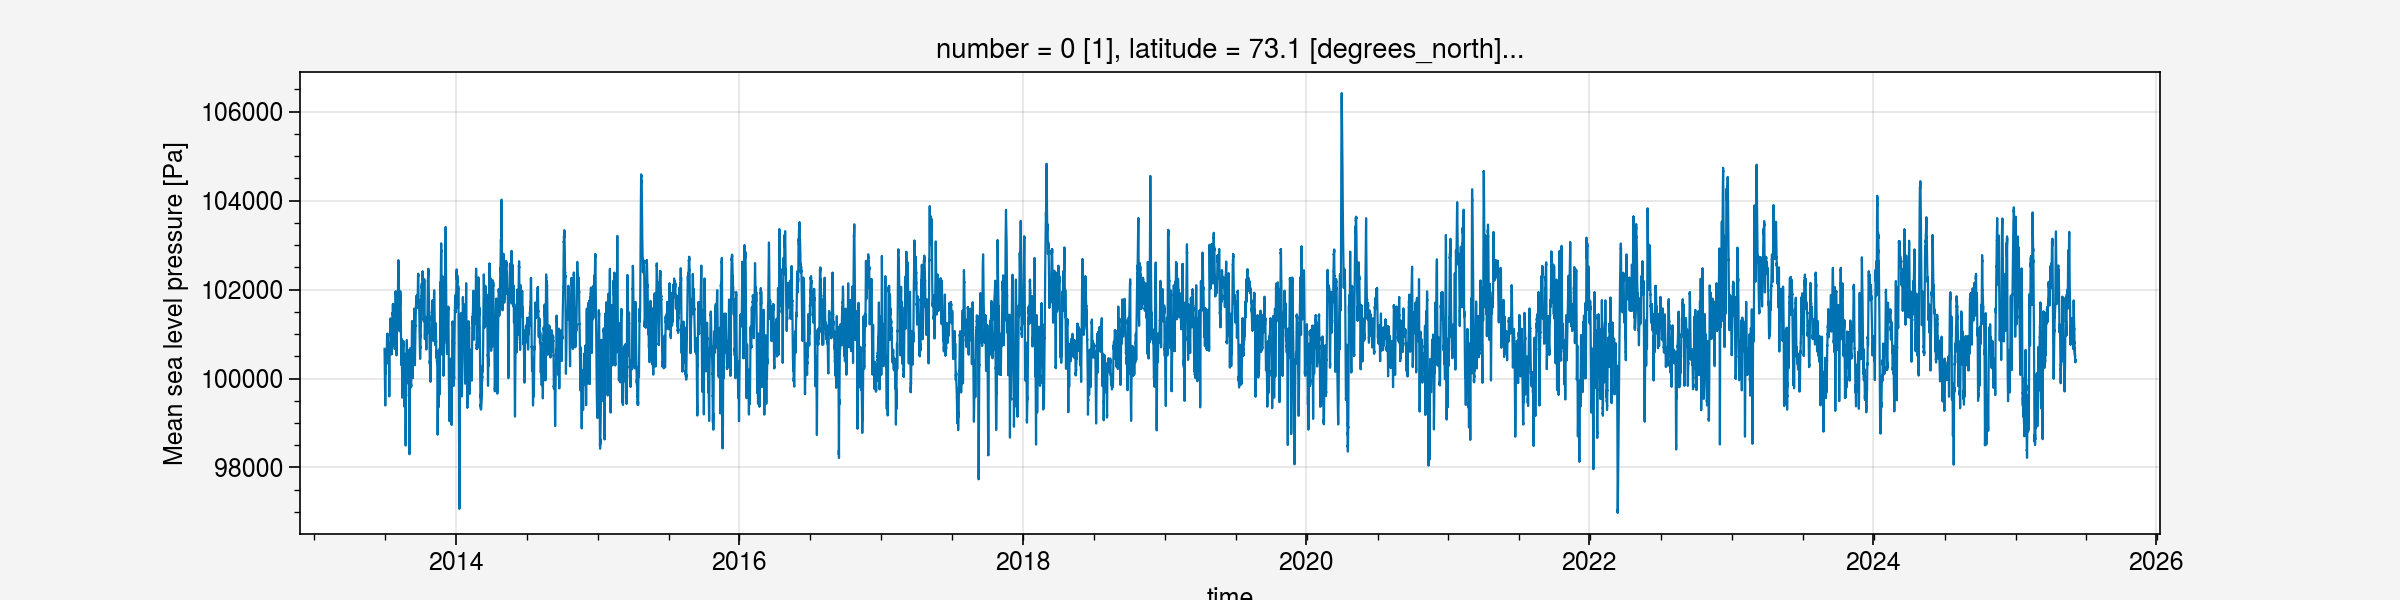

In [79]:
%matplotlib inline
ds_msl_concat.msl.sel(latitude=73.1, longitude=-80.05).plot(figsize=(12,3), lw=0.8)

## Gather all variable in one dataset

In [80]:
ds_all['msl'] = ds_msl_concat.msl
ds_all

<xarray.Dataset> Size: 15MB
Dimensions:     (valid_time: 108958, latitude: 2, longitude: 2)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 872kB 2013-01-01 ... 2025-06-06T2...
  * latitude    (latitude) float64 16B 73.35 73.1
  * longitude   (longitude) float64 16B -80.05 -79.8
    number      int64 8B 0
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
Data variables:
    strd        (valid_time, latitude, longitude) float32 2MB 137.8 ... 249.0
    str         (valid_time, latitude, longitude) float32 2MB -32.72 ... nan
    stru        (valid_time, latitude, longitude) float32 2MB 170.5 ... nan
    ssrd        (valid_time, latitude, longitude) float32 2MB 0.0 0.0 ... 544.6
    ssr         (valid_time, latitude, longitude) float32 2MB 1e-15 ... 278.7
    ssru        (valid_time, latitude, longitude) float32 2MB -1e-15 ... 265.9
    msl         (valid_time, latitude, longitude) float32 2MB nan ... 1.004e+05
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-04T20:54 GRIB to CDM+CF via cfgrib-0.9.1...

### Add Bylot TUNDRA coordinates

In [85]:
ds_all.latitude

<xarray.DataArray 'latitude' (latitude: 2)> Size: 16B
array([73.35, 73.1 ])
Coordinates:
  * latitude  (latitude) float64 16B 73.35 73.1
    number    int64 8B 0
Attributes:
    units:             degrees_north
    standard_name:     latitude
    long_name:         latitude
    stored_direction:  decreasing

In [86]:
# Ajouter les nouvelles coordonnées
new_lats = np.sort(np.append(ds_all.latitude.values, lat))
new_lons = np.sort(np.append(ds_all.longitude.values, lon))

In [83]:
new_lats

array([73.1   , 73.1504, 73.35  ])

In [84]:
new_lons

array([-80.05  , -80.0046, -79.8   ])

In [87]:
ds_interp = ds_all.interp(latitude=new_lats, longitude=new_lons)
ds_interp

<xarray.Dataset> Size: 58MB
Dimensions:     (valid_time: 108958, latitude: 3, longitude: 3)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 872kB 2013-01-01 ... 2025-06-06T2...
    number      int64 8B 0
    expver      (valid_time) <U4 2MB '0001' '0001' '0001' ... '0005' '0005'
  * latitude    (latitude) float64 24B 73.1 73.15 73.35
  * longitude   (longitude) float64 24B -80.05 -80.0 -79.8
Data variables:
    strd        (valid_time, latitude, longitude) float64 8MB 144.6 ... 239.9
    str         (valid_time, latitude, longitude) float64 8MB -45.95 ... nan
    stru        (valid_time, latitude, longitude) float64 8MB 190.6 ... nan
    ssrd        (valid_time, latitude, longitude) float64 8MB 0.0 0.0 ... 558.5
    ssr         (valid_time, latitude, longitude) float64 8MB 1e-15 ... 186.6
    ssru        (valid_time, latitude, longitude) float64 8MB -1e-15 ... 371.9
    msl         (valid_time, latitude, longitude) float64 8MB nan ... 1.004e+05
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-04T20:54 GRIB to CDM+CF via cfgrib-0.9.1...

In [88]:
import warnings
warnings.filterwarnings('ignore')

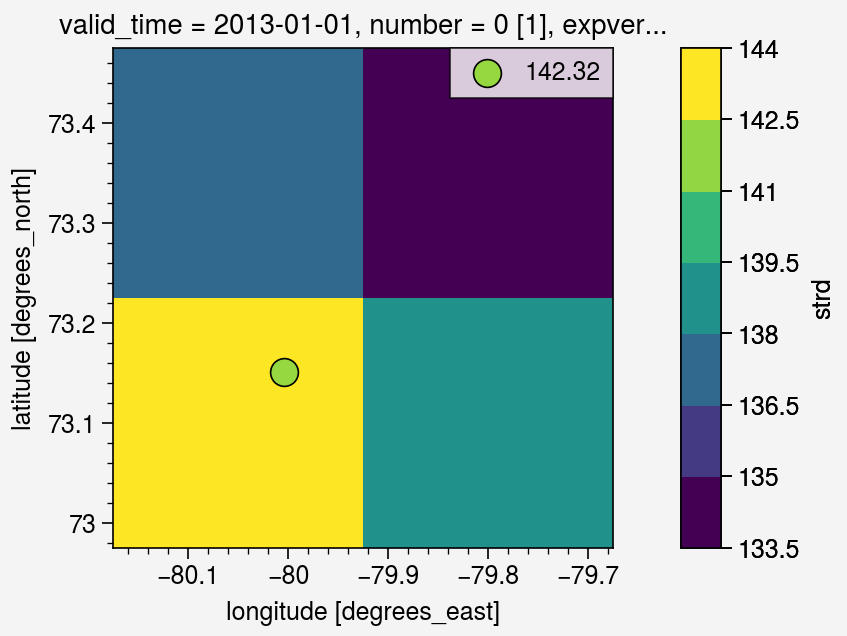

In [89]:
%matplotlib inline
fig, ax = pplt.subplots()

i_time = 0
pcolor = ds_all.strd[i_time].plot.pcolormesh(ax=ax)

# Récupérer les limites de la colorbar
vmin, vmax = pcolor.get_clim()

value = ds_interp.strd.sel(latitude=lat, longitude=lon)[i_time].item()  # Valeur scalaire

# Obtenir la couleur correspondante
import matplotlib.colors as mcolors  # Utilisation de matplotlib pour normaliser
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Normalisation correcte
cmap = pcolor.get_cmap()
color = cmap(norm(value))  # Convertir la valeur en couleur

# Ajouter le point avec la bonne couleur
ax.scatter(lon, lat, color=color, edgecolors="black", s=100, label=f"{value:.2f}")

# Afficher la légende
ax.legend()
pplt.show()

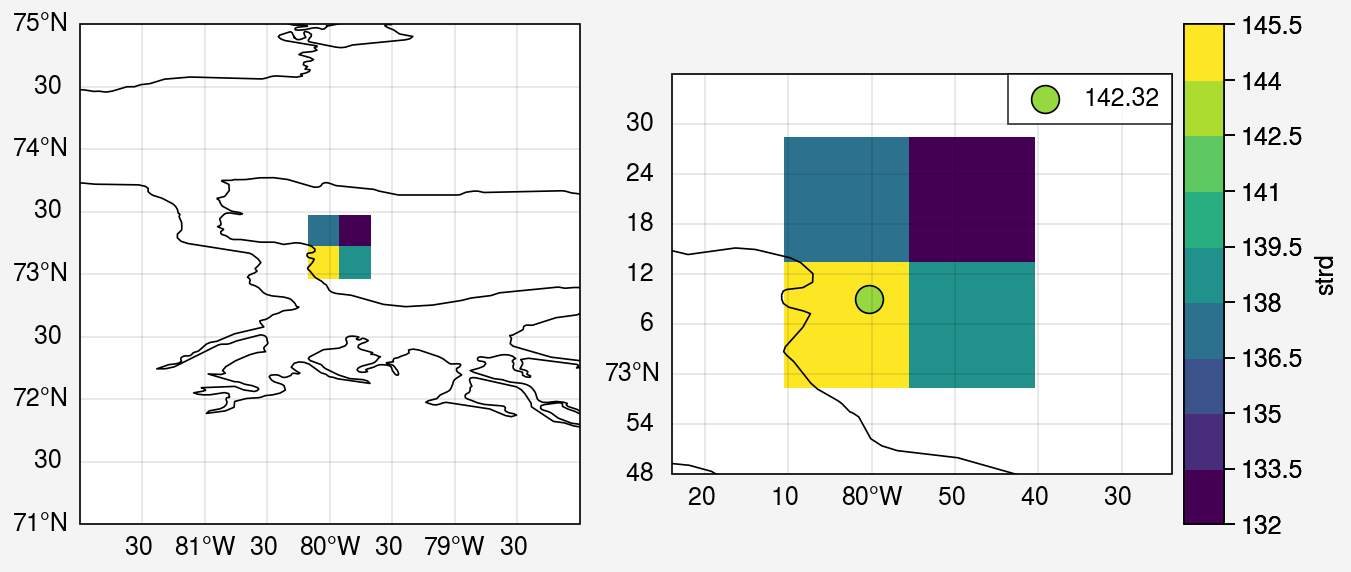

In [90]:
%matplotlib inline
fig, axs = pplt.subplots(proj='cyl', ncols=2)

i_time = 0
ax = axs[0]
ax.pcolormesh(ds_all.strd[i_time], cmap='viridis')

ax.format(
    borders=True, 
    coast=True, 
    labels=True, 
    latlim=(71, 75), 
    lonlim=(-82, -78),
    reso='hi'
)

ax = axs[1]
ax.pcolormesh(ds_all.strd[i_time], cmap='viridis', colorbar='r')

ax.format(
    borders=True, 
    coast=True, 
    labels=True, 
    latlim=(72.8, 73.6), 
    lonlim=(-79.4, -80.4),
    reso='hi'
)


# Récupérer les limites de la colorbar
vmin, vmax = pcolor.get_clim()

value = ds_interp.strd.sel(latitude=lat, longitude=lon)[i_time].item()  # Valeur scalaire

# Obtenir la couleur correspondante
import matplotlib.colors as mcolors  # Utilisation de matplotlib pour normaliser
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Normalisation correcte
cmap = pcolor.get_cmap()
color = cmap(norm(value))  # Convertir la valeur en couleur

# Ajouter le point avec la bonne couleur
ax.scatter(lon, lat, color=color, edgecolors="black", s=100, label=f"{value:.2f}")
ax.legend()

#reso : {'lo', 'med', 'hi', 'x-hi', 'xx-hi'}, optional


In [91]:
ds_interp.latitude.values

array([73.1   , 73.1504, 73.35  ])

In [92]:
ds_interp.longitude.values

array([-80.05  , -80.0046, -79.8   ])

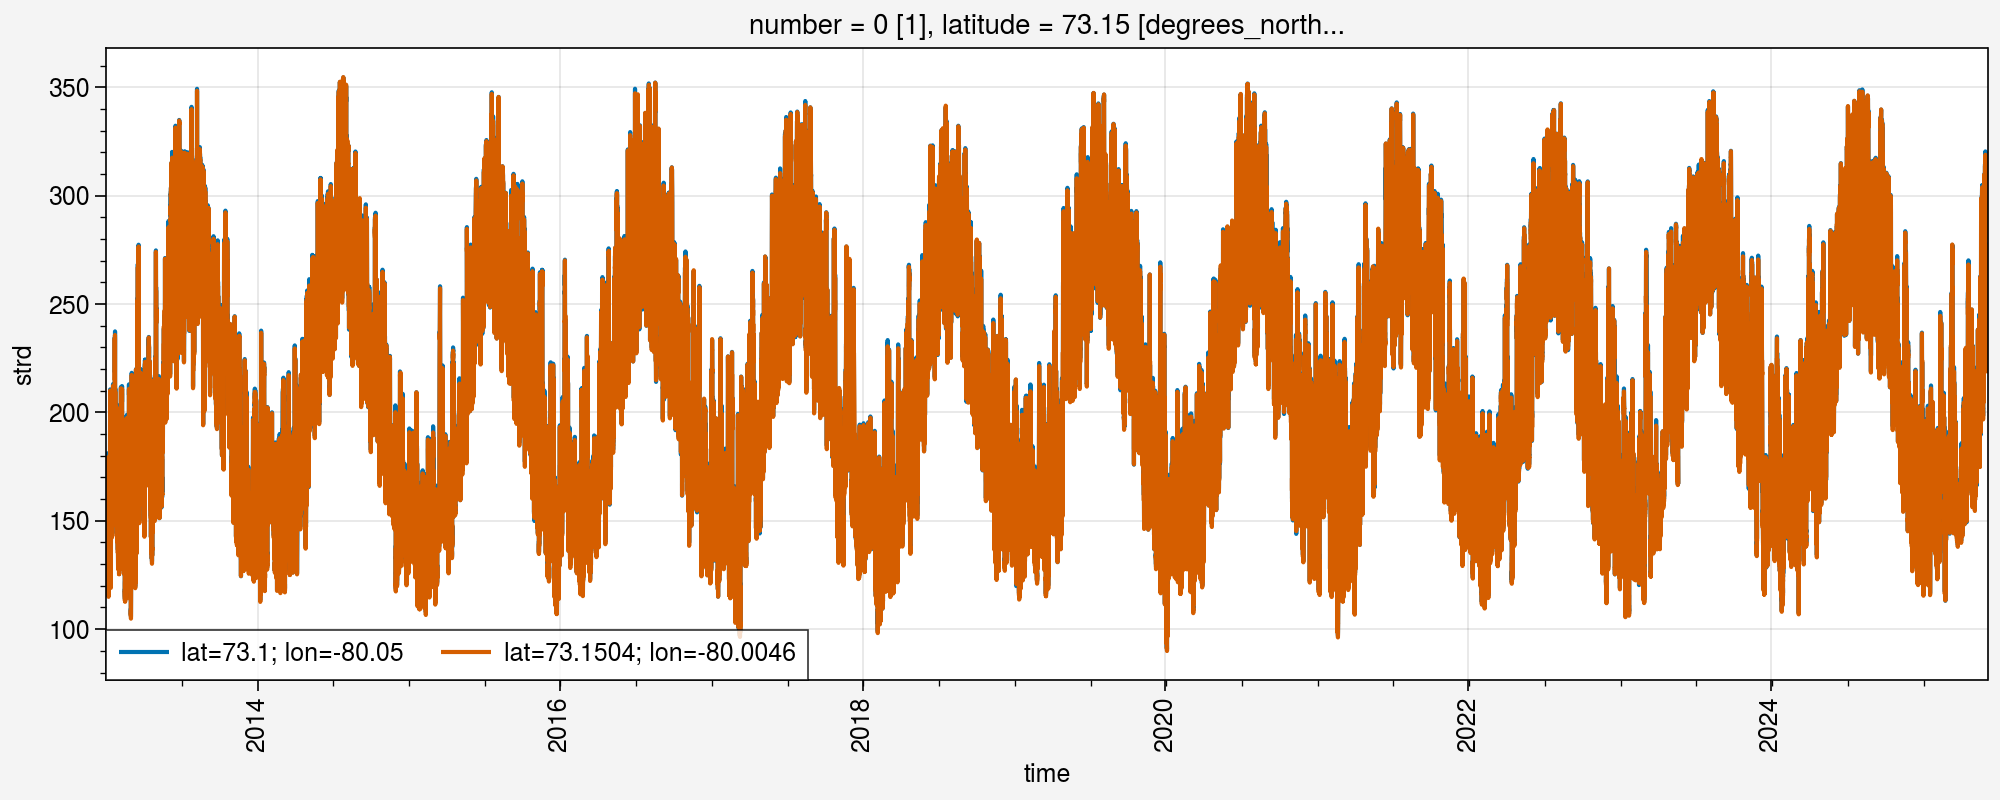

In [93]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,4))

ds_interp.strd.sel(latitude=73.1, longitude=-80.05).plot(ax=axs[0], label='lat=73.1; lon=-80.05')
ds_interp.strd.sel(latitude=73.1504, longitude=-80.0046).plot(ax=axs[0], label='lat=73.1504; lon=-80.0046')
axs.legend()

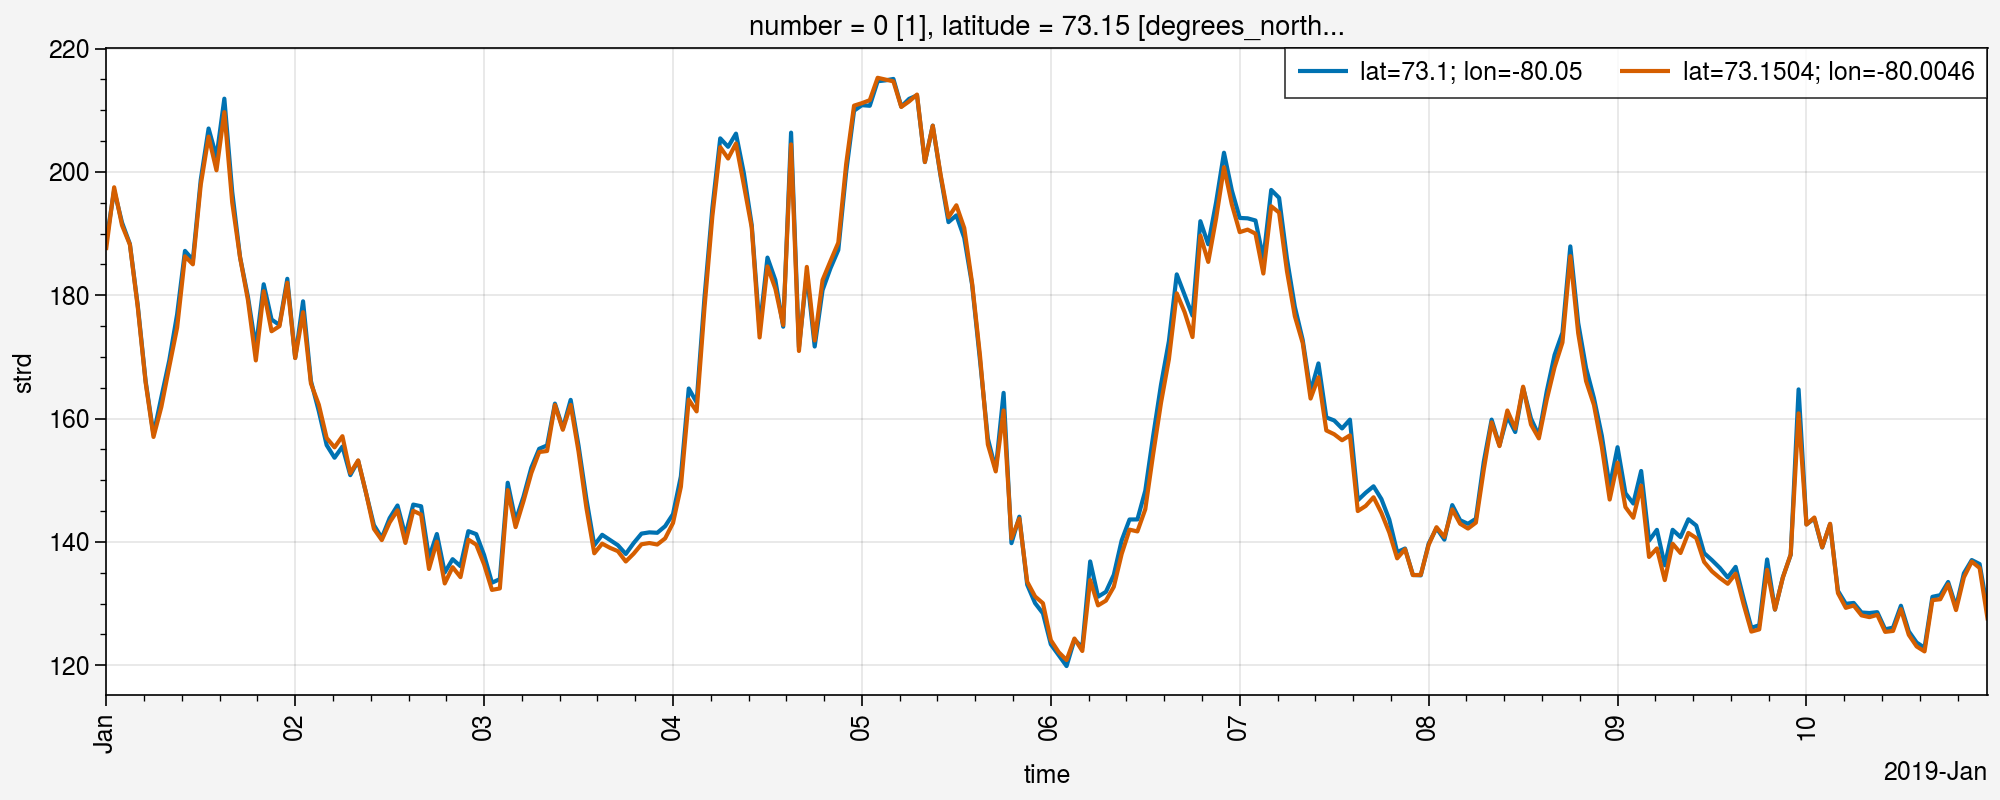

In [94]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,4))

ds_interp.strd.sel(latitude=73.1, longitude=-80.05, valid_time=slice('2019-01-01', '2019-01-10')).plot(ax=axs[0], label='lat=73.1; lon=-80.05')
ds_interp.strd.sel(latitude=73.1504, longitude=-80.0046, valid_time=slice('2019-01-01', '2019-01-10')).plot(ax=axs[0], label='lat=73.1504; lon=-80.0046')
axs.legend()

Need to divide by 3600 to get W m-2 s-1

## Export data to .dat or .csv 
Only pixel including Bylot and interpolated values

In [98]:
ds_interp_out = ds_interp.drop('number').drop('expver').rename({'valid_time': 'time', 'latitude': 'lat', 'longitude': 'lon'})
ds_interp_out = ds_interp_out.sel(time=slice('2013-07', '2025-05'))

ds_interp_out_grid = ds_interp_out.sel(lat=73.1, lon=-80.05)
ds_interp_out_interp = ds_interp_out.sel(lat=73.1504, lon=-80.0046)
ds_interp_out_grid

<xarray.Dataset> Size: 7MB
Dimensions:  (time: 104472)
Coordinates:
  * time     (time) datetime64[ns] 836kB 2013-07-01 ... 2025-05-31T23:00:00
    lat      float64 8B 73.1
    lon      float64 8B -80.05
Data variables:
    strd     (time) float64 836kB 315.0 319.2 318.7 318.9 ... 314.5 312.6 302.7
    str      (time) float64 836kB -0.9166 3.479 3.224 ... -1.321 -3.132 -13.2
    stru     (time) float64 836kB 316.0 315.7 315.4 315.2 ... 315.9 315.7 315.9
    ssrd     (time) float64 836kB 79.9 62.42 39.64 23.82 ... 161.7 181.7 227.8
    ssr      (time) float64 836kB 48.41 40.06 24.23 14.68 ... 67.81 79.37 103.1
    ssru     (time) float64 836kB 31.49 22.35 15.41 9.142 ... 93.86 102.3 124.7
    msl      (time) float64 836kB 1.007e+05 1.006e+05 ... 1.008e+05 1.009e+05
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-04T20:54 GRIB to CDM+CF via cfgrib-0.9.1...

In [99]:
df_grid = ds_interp_out_grid.to_dataframe()
df_grid

strd        str        stru        ssrd  \
time                                                                 
2013-07-01 00:00:00  315.046936  -0.916571  315.963501   79.895958   
2013-07-01 01:00:00  319.215271   3.479315  315.735962   62.419113   
2013-07-01 02:00:00  318.663055   3.223636  315.439423   39.638577   
2013-07-01 03:00:00  318.901123   3.693412  315.207703   23.819931   
2013-07-01 04:00:00  319.697723   4.564531  315.133209   18.759062   
...                         ...        ...         ...         ...   
2025-05-31 19:00:00  307.912567  -8.774007  316.686554  290.408539   
2025-05-31 20:00:00  312.209381  -4.226526  316.435913  222.138535   
2025-05-31 21:00:00  314.545563  -1.321130  315.866699  161.668762   
2025-05-31 22:00:00  312.601593  -3.132405  315.733978  181.705902   
2025-05-31 23:00:00  302.667633 -13.198252  315.865906  227.810883   

                            ssr        ssru            msl   lat    lon  
time                                                                     
2013-07-01 00:00:00   48.409863   31.486094  100666.820312  73.1 -80.05  
2013-07-01 01:00:00   40.064514   22.354601  100635.570312  73.1 -80.05  
2013-07-01 02:00:00   24.227877   15.410699  100565.257812  73.1 -80.05  
2013-07-01 03:00:00   14.677595    9.142335  100494.359375  73.1 -80.05  
2013-07-01 04:00:00   10.979135    7.779928  100470.750000  73.1 -80.05  
...                         ...         ...            ...   ...    ...  
2025-05-31 19:00:00  127.763557  162.644958  100722.703125  73.1 -80.05  
2025-05-31 20:00:00   94.166962  127.971581  100746.929688  73.1 -80.05  
2025-05-31 21:00:00   67.808128   93.860641  100772.234375  73.1 -80.05  
2025-05-31 22:00:00   79.368141  102.337761  100829.476562  73.1 -80.05  
2025-05-31 23:00:00  103.137482  124.673401  100862.312500  73.1 -80.05  

[104472 rows x 9 columns]

In [100]:
df_grid.to_csv(path+'/ERA5_h_all_73.1N_80.05W_201307-202505_Bylot_UTC_0005.csv')